# preliminaries

## load packages

In [213]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data 
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#plotting
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt

# custom code
from src import features, annotation, parameters, segmentation, spectrogramming


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## define path variables

In [69]:
#paths to raw data
all_wav_development = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/'
all_wav_bw_po_cf = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_cf/'
all_wav_bw_po_f1 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_f1/'
all_wav_bw_po_f2 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_f2/'

#paths to clips for developmental dataset
all_voc_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/vocalization_clips/'
all_bg_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/background_clips/'

#root directory for all of the segments (start and stop times)
segments_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/'
annotations_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'
acoustic_features_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/'
clips_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/'
specs_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/'
noise_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/noise/'
snr_clipping_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/snr_clipping/amplitude_segmented/'
models_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/'
noise_floors_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/noise/all_noise_floors.csv'

#csv of annotated segments (start and stop times) from the development dataset
test_set_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/annotated/annotations_csv/all_annotations.csv'

#amplitdue segments
amplitude_acoustic_features = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/development/20220913_063001/'
amplitude_umap = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmented/final/umap_coordinates/'
amplitude_umap_HDBSCAN_labeled = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'
amplitude_segments_csv = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/amplitude_segmented/final/all_predictions.csv'
amplitude_voc_clips = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/vocalization_clips/'
amplitude_bg_clips = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/background_clips/'


#params dict path
params_dict_path = '/n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/'


# Figure 1

## color UMAP by HDBSCAN cluster (Figure 1C top)

### collect UMAP data

In [4]:
#choose the directories you want and print the embeddings you have available to plot
coords_dir = amplitude_umap_HDBSCAN_labeled
coords_list = os.listdir(coords_dir)

print('coordinates available...')
for i in coords_list: 
    print(i)

coordinates available...
SW
BK
LL
LO
all_species_HDBSCAN_labels.csv
MU
PO
NB
all_species_HDBSCAN_labels.feather
MZ
BW
GO


In [42]:
#choose species decide what to save
species = 'MZ'
save_umap_plot = False
save_labeled_umap_plot = False
save_label_verification = False

#load the coordinates
coords_path = glob.glob(coords_dir+species+'/*labeled.feather')[0]
df_umap = pd.read_feather(coords_path)

#just get the coordinates
df_umap_small = df_umap[['umap1', 'umap2', 'source_file', 'label']]


### plot with HDBSCAN labels

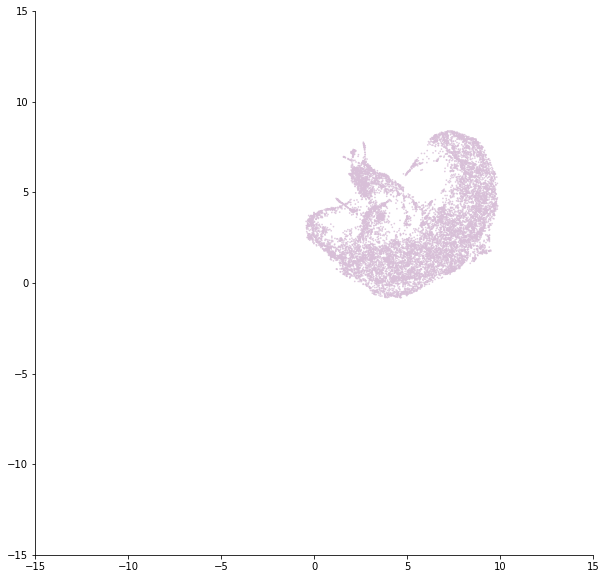

In [43]:
#decide to save or not
save_labeled_umap_plot = False

#show the umap plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

if species in ['MU', 'MZ']: #color dictionary for MU and MZ - make points ignored by HDBSCAN the same color as the
                            #the ones it considered "clusters"
    HDBSCAN_color_dict = {0: 'thistle', 
                          -1:'thistle'}
else: #color dictionary for Peromyscus taxa
    HDBSCAN_color_dict = {0: 'thistle', 
                          1: 'deeppink'}

colmap = df_umap['label'].map(HDBSCAN_color_dict)

ax = plt.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = colmap,
    s = .5,
    alpha = .75, 
    cmap=None)

xlims = [-15,15]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)
sns.despine()

if save_labeled_umap_plot:
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_plots/'
    save_name = ('_').join([species,'final_amplitude_HDBSCAN_labeled_umap.jpeg'])
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)

plt.show()


## Average spectrograms (Figure 1C middle/bottom)

In [44]:
#set the path to the vocalization clips and make sure it exists
clips_dir = os.path.join(amplitude_voc_clips, species)
assert os.path.exists(clips_dir)

#get path to each wav clip
all_files = [os.path.join(clips_dir,i) for i in df_umap['source_file']]

In [48]:
os.path.join(amplitude_voc_clips, species)

'/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/vocalization_clips/MZ'

In [45]:
#set the spectrogram parameters
spec_params = {
    'min_freq': 5000, # minimum frequency
    'max_freq': 125000, # maximum frequency
    'nperseg': 512, # FFT
    'noverlap': 512 // 4, # FFT
    'spec_min_val': 0.5, # minimum log-spectrogram value - update from noise floors if noise_floors_path provided
    'fs': 250000, # audio samplerate
    'fill_value': 0.5,
    'max_duration':0.5, #set the max duration of each spectrogram to 0.5 seconds for all vocs and species
    'num_time_bins':256,
    'num_freq_bins':256,
    'spec_max_val':10
}

In [46]:
#generate the spectrograms

if species not in ['MU', 'MZ']: #if there are two clusters, generate spectrograms separately for each one
    
    label_0_files = [os.path.join(clips_dir,i) for i in df_umap['source_file'].loc[df_umap['label'] == 0]]
    label_1_files = [os.path.join(clips_dir,i) for i in df_umap['source_file'].loc[df_umap['label'] == 1]]
    
    #get the label 0 specs
    label_0_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = label_0_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    #get the label 1 specs
    label_1_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = label_1_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')


else:
    #get all the specs
    all_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                        noise_floors_path=noise_floors_path, 
                                                        species = None, 
                                                        filtered_clips = all_files,
                                                        noise_floor = None,
                                                        spec_params=spec_params, 
                                                        num_to_process = 'all')


generating specs from the paths in the list filtered_clips...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12045/12045 [04:21<00:00, 46.07it/s]

done.


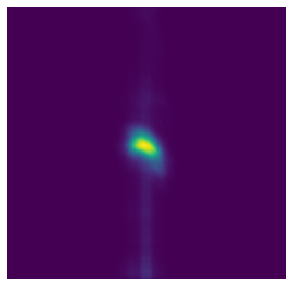

In [50]:
save = False

############################################################################################################

if species not in ['MU', 'MZ']: 
    
    #average the spectrograms you just generated
    label0_spec_avg = spectrogramming.spec_avg_from_list(label_0_specs_list)
    label1_spec_avg = spectrogramming.spec_avg_from_list(label_1_specs_list)

    #set up the figure
    fig, axes = plt.subplots(nrows=2, 
                             ncols=1, 
                             figsize=(5,10))
    
    
    #plot label 0 average
    axes[0].set_axis_off()
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[0].matshow(label0_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")
    
    #plot label 1 average
    axes[1].set_axis_off()
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[1].matshow(label1_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")
    
    #save 
    if save:
        save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_plots/'
        save_name = ('_').join([species,'_HDBSCAN_all_vocs_common_duration.jpeg'])
        plt.savefig(fname=save_dir+save_name, dpi=600)
    
else: 
    
    #average the spectrograms you just generated
    all_spec_avg = spectrogramming.spec_avg_from_list(all_specs_list)

    #set up the figure
    fig, axes = plt.subplots(nrows=1, 
                             ncols=1, 
                             figsize=(5,5))
    
    
    #plot label 0 average
    axes.set_axis_off()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    axes.matshow(all_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

    #save 
    if save:
        save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_plots/'
        save_name = ('_').join([species,'_HDBSCAN_all_vocs_common_duration.jpeg'])
        plt.savefig(fname=save_dir+save_name, dpi=600)
    
    

## PCA of acoustic features (Figure 1 panel D)

### set color palettes

In [225]:
#collect the coustic features into a single csv

species_color_dict = {'BW':'steelblue',
                      'NB': 'dodgerblue',
                      'BK': 'darkblue',
                      'SW': 'blue',
                      'PO': 'orange',
                      'LO': 'gold',
                      'GO': 'green',
                      'LL': 'forestgreen',
                      'MU': 'mediumspringgreen', 
                      'MZ': 'turquoise'}

genus_color_dict = {'BW':'black',
                    'NB': 'black',
                    'BK': 'black',
                    'SW': 'black',
                    'PO': 'black',
                    'LO': 'black',
                    'GO': 'black',
                    'LL': 'black',
                    'MU': 'mediumspringgreen', 
                    'MZ':'turquoise'}

voc_name_color_dict = {'cry': 'deeppink', 
                       'whistle': 'thistle'}

HDBSCAN_color_dict = {0: 'thistle', 
                      1: 'deeppink', 
                      -1:'thistle'}

### set metadata and wableR acoustic features

In [42]:
#info about the vocalizer
metadata = ['species',
           'individual',
           'sex',
           'age', 
           'source_file',
           'label', 
            'weight_mg', 
            'removal_flag', 
            'genus']

#basic summary statistics calculated by warbleR
base_features = ['duration',
                 'time.median', 
                 'time.Q25', 
                 'time.Q75', 
                 'time.IQR', 
                 'meanfreq', 
                 'freq.median', 
                 'freq.Q25', 
                 'freq.Q75', 
                 'freq.IQR', ]

#additional features calculated by warbleR
extra_features = ['meanpeakf', 
                  'dfslope', 
                  'enddom', 
                  'startdom', 
                  'modindx', 
                  'dfrange', 
                  'sfm', 
                  'entropy',  
                  'sp.ent', 
                  'time.ent', 
                  'sd',                  
                  'meandom', 
                  'mindom', 
                  'maxdom', 
                  'skew', 
                  'kurt']


### get/clean the features and UMAP cluster labels for all species

In [6]:
#get umap cluster labels
print('getting umap HDBSCAN labels...')
umap_labels = os.path.join(amplitude_umap_HDBSCAN_labeled,'all_species_HDBSCAN_labels.csv')
umap_df = pd.read_csv(umap_labels)

#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#remove 85 MU "vocalizations" that are recording artefacts (not in umap embedding)
dropped = features_df['source_file'].loc[~features_df['source_file'].isin(umap_df['source_file'])]
features_df = features_df.loc[~features_df['source_file'].isin(dropped)]

#remove vocalizations that have nan for at least one acoustic feature (all of these are from MU)
nans = features_df['source_file'].iloc[pd.isnull(features_df).any(1).to_numpy().nonzero()]
features_df = features_df.loc[~features_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)
umap_df = umap_df.loc[~umap_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)

#make sure the source files are identical and merge
print('merging...')
assert umap_df['source_file'].equals(features_df['source_file'])
merged_df = features_df.merge(umap_df, on='source_file')

print('done.')

getting umap HDBSCAN labels...
getting features...
merging...
done.


### do PCA

In [207]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#get the features
features_set = base_features+extra_features
pca_df = features_df[features_set]

# Standardizing the features
standardized_features = StandardScaler().fit_transform(pca_df)

#2 component PCA
print('doing PCA...')
pca = PCA(n_components = 2)
pca_embedding = pca.fit_transform(standardized_features)
print('\texplained variance by PC:', pca.explained_variance_ratio_)
print('\ttotal variance explained:', sum(pca.explained_variance_ratio_))

#add to features_df
features_df['pc_1'] = pca_embedding[:,0]
features_df['pc_2'] = pca_embedding[:,1]

print('done.')

doing PCA...
	explained variance by PC: [0.51093306 0.11144792]
	total variance explained: 0.6223809859380659
done.


### get PCA loadings

In [208]:
loadings = pd.DataFrame(pca.components_.T, columns=['pc1', 'pc2'], index=df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])
loadings = loadings.sort_values(by = ['pc1'], ascending=False)

### plot

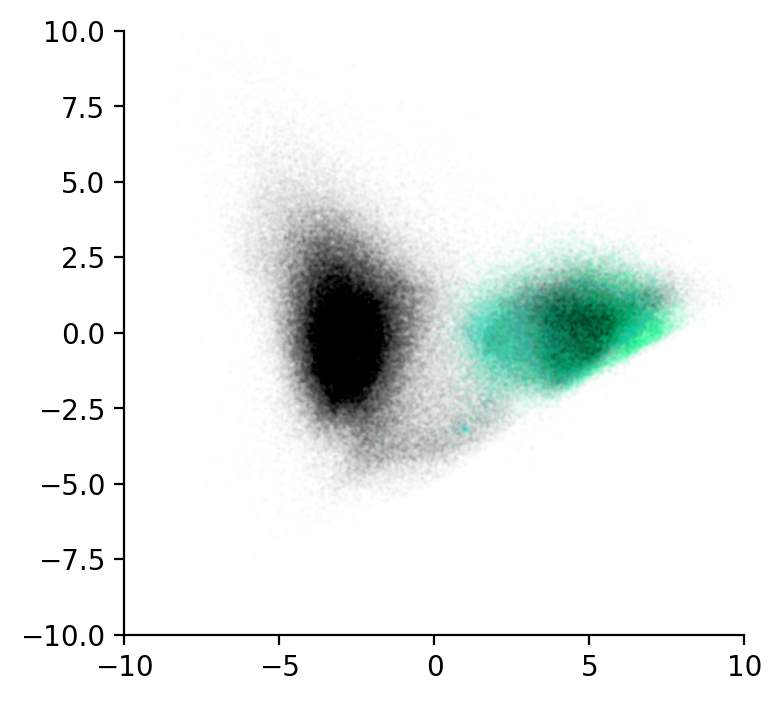

In [209]:
fig = plt.figure(figsize = [4,4], dpi= 200)
ax1 = fig.add_subplot(1,1,1)

colors = features_df['species'].map(genus_color_dict)

#plot Peromyscus
ax1.scatter(features_df['pc_1'].loc[~features_df['species'].isin(['MU', 'MZ'])], 
            features_df['pc_2'].loc[~features_df['species'].isin(['MU', 'MZ'])],
            c= features_df['species'].loc[~features_df['species'].isin(['MU', 'MZ'])].map(genus_color_dict),
            alpha = .0075, 
            s=.5)

#plot Mus
ax1.scatter(features_df['pc_1'].loc[features_df['species'].isin(['MU', 'MZ'])], 
            features_df['pc_2'].loc[features_df['species'].isin(['MU', 'MZ'])],
            c= features_df['species'].loc[features_df['species'].isin(['MU', 'MZ'])].map(genus_color_dict),
            alpha = .02, 
            s=.5)

ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])

sns.despine()

## Violin Plots of Acoustic Features by Species (Figure 1E)

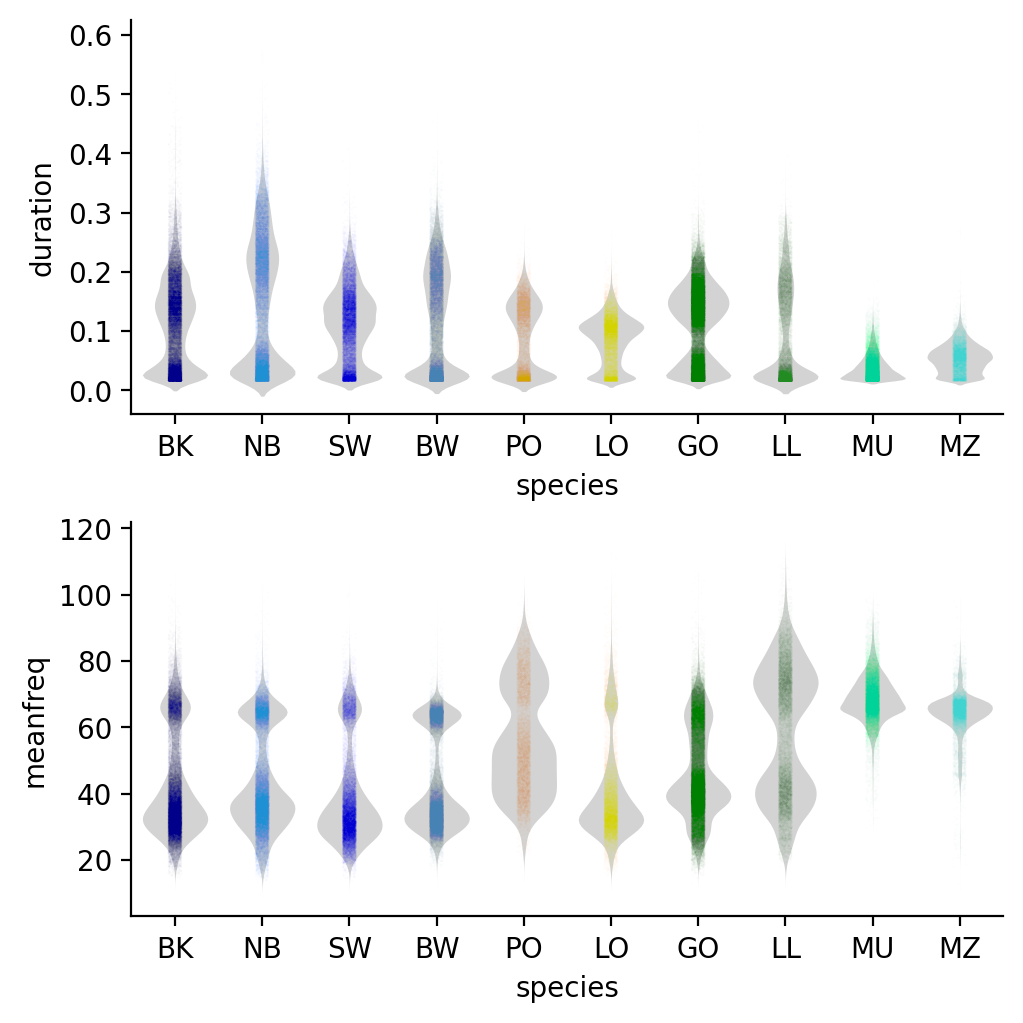

In [210]:

#set up the figures
fig = plt.figure(figsize = [5,5], constrained_layout=True, dpi=200)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
order = ['BK', 'NB', 'SW', 'BW', 'PO', 'LO', 'GO', 'LL', 'MU', 'MZ']

#plot the dots
sns.stripplot(data = features_df, ax = ax1, y='duration', x='species', hue = 'species', alpha=.01, s=.75, jitter=.075, order=order, palette = species_color_dict)
sns.stripplot(data = features_df, ax = ax2, y='meanfreq',x='species', hue = 'species', alpha=.01, s=.75, jitter=.075, order=order, palette = species_color_dict)

#plot the violins
sns.violinplot(data = features_df, ax = ax1, y='duration', x='species', scale = 'width', width = .75, alpha=1, order=order, inner=None, color = 'lightgray', linewidth=0)
sns.violinplot(data = features_df, ax = ax2, y='meanfreq', x='species', scale = 'width', width = .75, alpha=1, order=order, inner=None, color = 'lightgray', linewidth=0)

#remove the unecessary boundaries and legends
sns.despine()
ax1.legend([],[], frameon = False)
ax2.legend([],[], frameon = False)

## Hierarchical Clustering of Acoustic Features (Figure 1 panel F)

### sample the data

In [230]:
from sklearn.preprocessing import MinMaxScaler

#set seed for reproducible sampling
seed = 123456

#get the features
features_set = base_features+extra_features

#sample 50,000 vocalizations (otherwise too memory intensive)
cluster_df = merged_df.sample(n=50000, random_state=seed)
print('sampled',len(cluster_df),'vocalizations...')

#scale the columns 
print('scaling...')
standardized_features = pd.DataFrame(MinMaxScaler().fit_transform(cluster_df[features_set]), columns = features_set, index=cluster_df.index)
standardized_features = standardized_features[features_set]

print('done.')

sampled 50000 vocalizations...
scaling...
done.


### cluster

In [231]:
from sklearn.cluster import AgglomerativeClustering, KMeans

#define the distance below which leaves will not be merged
distance_threshold = 90

#define the clustering model to use
clusterer = AgglomerativeClustering(n_clusters=None, 
                                    affinity='euclidean', 
                                    linkage='ward', 
                                    compute_full_tree=True, 
                                    distance_threshold = distance_threshold)
#use it
print('clustering...')
clusterer.fit_predict(standardized_features)

#get clustering results
cluster_labels = clusterer.labels_
num_clusters = clusterer.n_clusters_

print('done.')

clustering...
done.


### plot

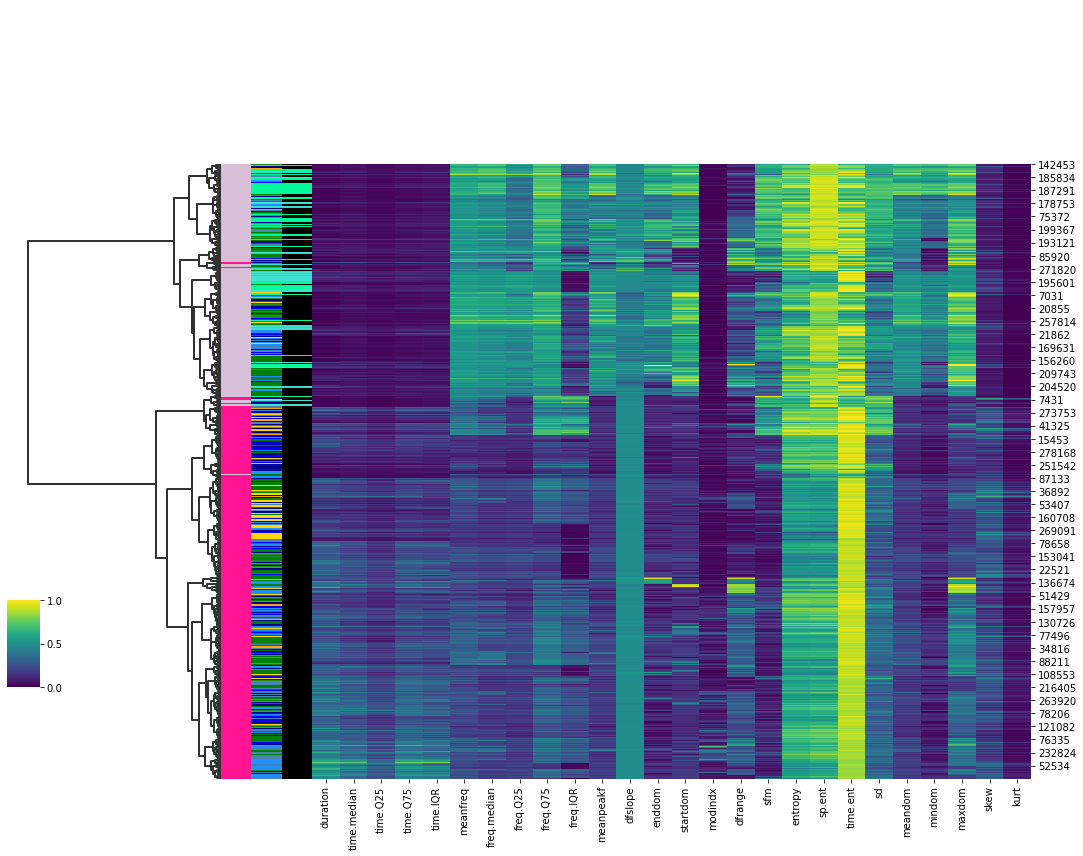

In [232]:
#may take a few minutes

#set the colors
voc_colmap = cluster_df['label'].map(HDBSCAN_color_dict)
species_colmap = cluster_df['species_x'].map(species_color_dict)
genus_colmap = cluster_df['species_x'].map(genus_color_dict)
row_colors = [voc_colmap, species_colmap, genus_colmap]

#plot
sns.clustermap(standardized_features,
               method = 'ward', 
               cmap = 'viridis', 
               col_cluster=False,
               figsize = (15, 12),
               cbar_pos=(0, .2, .03, .1),
               row_colors = row_colors, 
               mask = None, 
               colors_ratio=.03, 
               tree_kws={'linewidth':2})


# Figure 2

## get model to predict vocalization types (cry, USV, non-vocal)

In [5]:
#path to model for labeling amplitude segmented vocalizations as cry, scratch or whistle
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
model_params = parameters.load_parameters(save_dir=os.path.split(voc_type_params_path)[0], 
                                          save_name=os.path.split(voc_type_params_path)[1])


loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230116_084254/random_forest_20230116_084254_params


## get/clean features

In [6]:
#get umap cluster labels
print('getting umap HDBSCAN labels...')
umap_labels = os.path.join(amplitude_umap_HDBSCAN_labeled,'all_species_HDBSCAN_labels.csv')
umap_df = pd.read_csv(umap_labels)

#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#remove 85 MU "vocalizations" that are recording artefacts (not in umap embedding)
dropped = features_df['source_file'].loc[~features_df['source_file'].isin(umap_df['source_file'])]
features_df = features_df.loc[~features_df['source_file'].isin(dropped)]

#remove vocalizations that have nan for at least one acoustic feature (all of these are from MU)
nans = features_df['source_file'].iloc[pd.isnull(features_df).any(1).to_numpy().nonzero()]
features_df = features_df.loc[~features_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)
umap_df = umap_df.loc[~umap_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)

#make sure the source files are identical and merge
print('merging...')
assert umap_df['source_file'].equals(features_df['source_file'])
merged_df = features_df.merge(umap_df, on='source_file')
assert(merged_df['species_x'].equals(merged_df['species_y']))
merged_df = merged_df.rename(columns={'species_x':'species'}).drop(columns=['species_y'])
merged_df['pup'] = [i.split('_clip')[0] for i in merged_df['source_file']]

#drop pups whose recordings were found to contain artefacts (vertical lines caused by data transfer issue) during annotation
pups_to_drop = ['BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
                'BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
                'GO_24860x23748_ltr2_pup4_ch5_4700_m_324_292_fr0_p9_2021-10-02_12-35-01',
                'GO_23883x23084_ltr2_pup4_ch6_6100_f_329_304_fr0_p11_2019-12-03_10-35-37']

print('dropping', len(merged_df.loc[merged_df['pup'].isin(pups_to_drop)]), 'vocs because they come from bad recordings...')
merged_df = merged_df.loc[~merged_df['pup'].isin(pups_to_drop)]
assert len(merged_df.loc[merged_df['pup'].isin(pups_to_drop)]) == 0

print('done.')

getting umap HDBSCAN labels...
getting features...
merging...
dropping 3488 vocs because they come from bad recordings...
done.


## predict vocalization labels from features 

In [7]:
#this takes a few minutes 

#get the features you trained on
for_prediction = merged_df[model_params['feature_set']]

#predict vocalization type from those features
predicted_labels = voc_type_model.predict(for_prediction)

#add them to the dataset
merged_df['predicted_label'] = predicted_labels
merged_df['predicted_label'] = ['USV' if i == 'whistle' else i for i in merged_df['predicted_label']]

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


## general average spectrograms by label (Supplemental Figure ## Panel ##)

In [8]:
#make the spectrograms using a common max duration for all vocalizations and species (.5 seconds)
species_list = ['BK'] 

for species in species_list:
    print(species)
    max_dur = 0.5
    clips_dir = os.path.join(amplitude_voc_clips, species)
    cry_files = [os.path.join(clips_dir,i) for i in merged_df['source_file'].loc[merged_df['predicted_label'] == 'cry'].loc[merged_df['species'] == species]]
    USV_files = [os.path.join(clips_dir,i) for i in merged_df['source_file'].loc[merged_df['predicted_label'] == 'USV'].loc[merged_df['species'] == species]]
    scratch_files = [os.path.join(clips_dir,i) for i in merged_df['source_file'].loc[merged_df['predicted_label'] == 'scratch'].loc[merged_df['species'] == species]]

    spec_params = {
        'min_freq': 5000, # minimum frequency
        'max_freq': 125000, # maximum frequency
        'nperseg': 512, # FFT
        'noverlap': 512 // 4, # FFT
        'spec_min_val': 0.5, # minimum log-spectrogram value - update from noise floors dataframe if noise_floors_path provided
        'fs': 250000, # audio samplerate
        'downsample_by':2, #2 means take every other pixel from the original spectrogram - only usedin interpolate = False
        'log_resize_scaling_factor':None, 
        'fill_value': .5,
        'max_duration':max_dur,
        'num_time_bins':256,
        'num_freq_bins':256,
        'spec_max_val':10
    }


    print('getting cry specs...')
    cry_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = cry_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    print('getting USV specs...')
    USV_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = USV_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    print('getting scratch specs...')
    scratch_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = scratch_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    


In [ ]:
#show the specs
save = False

cry_spec_avg = spectrogramming.spec_avg_from_list(cry_specs_list)
USV_spec_avg = spectrogramming.spec_avg_from_list(USV_specs_list)
scratch_spec_avg = spectrogramming.spec_avg_from_list(scratch_specs_list)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

print('making cry spec...')
ax1.set_axis_off()
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title(species+' predicted cry n='+str(len(cry_specs_list)))
ax1.matshow(cry_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

print('making USV spec...')
ax2.set_axis_off()
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title(species+' predicted USV n='+str(len(USV_specs_list)))
ax2.matshow(USV_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

print('making scratch spec...')
ax3.set_axis_off()
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title(species+' predicted nonvocal n='+str(len(scratch_specs_list)))
ax3.matshow(scratch_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

#save it
if save:
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/panels/'
    save_name = ('_').join([species,'RF_predicted_labels_20230127.jpeg'])
    print(save_dir+save_name)
    plt.savefig(fname=save_dir+save_name, dpi=600)

# del cry_spec_avg
# del USV_spec_avg
# del scratch_spec_avg
# del cry_specs_list
# del USV_specs_list
# del scratch_specs_list

## aggregate labeled vocalizations by pup

In [8]:
#get the features to aggregate

#path to params (and features) for labeling amplitude segmented vocalizations as cry, scratch or whistle 
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_params')

#load the training parameters
model_params = parameters.load_parameters(save_dir=os.path.split(voc_type_params_path)[0], 
                                          save_name=os.path.split(voc_type_params_path)[1])

features_to_aggregate = model_params['feature_set']

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230116_084254/random_forest_20230116_084254_params


In [9]:
#choose the dataset

dataset='development'
raw_wavs_root = all_wav_development    

#get the pups that you want to aggregate features from
print('getting pups...')

#exclude pups that have recording artefacts
pups_to_drop = ['NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13.wav',
            'SW_29542x30031_ltr1_pup7_ch8_1600_m_348_263_fr0_p1_2022-01-05_10-54-58.wav',
            'BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41.wav',
            'BK_26464x25680_ltr1_pup7_ch8_7300_m_305_301_fr0_p13_2021-08-24_09-30-30.wav',
            'GO_24860x23748_ltr2_pup4_ch5_4700_m_324_292_fr0_p9_2021-10-02_12-35-01.wav',
            'GO_23883x23084_ltr2_pup4_ch6_6100_f_329_304_fr0_p11_2019-12-03_10-35-37.wav']

#only aggregate features from pups who vocalized and only from non-IS deer mice
vocalizing_pups = [('.').join([i,'wav']) for i in sorted(merged_df['pup'].unique())]
source_list = [i for i in vocalizing_pups if i not in pups_to_drop and i.split('_')[0] not in ['MZ', 'MU', 'IS']]

#aggregate the data - this takes a few minutes
print('getting aggregate features for each pup...')
all_pup_features, all_pup_metadata = features.aggregate_all_pups(source_list = source_list, 
                                                                 dataset = 'development', 
                                                                 features = features_to_aggregate, 
                                                                 features_df = merged_df) 
print('done.')

getting pups...
getting aggregate features for each pup...
done collecting metadata...
BK_24224x25894_ltr1_pup1_ch2_3700_m_358_302_fr0_p5_2021-10-22_11-05-10.wav
BK_24224x25894_ltr2_pup1_ch2_2200_m_336_267_fr0_p5_2021-11-16_09-52-17.wav
BK_24224x25894_ltr3_pup1_ch2_4400_m_338_313_fr0_p9_2021-12-16_10-42-08.wav
BK_24224x25894_ltr3_pup2_ch3_5200_f_335_326_fr0_p9_2021-12-16_10-42-08.wav
BK_24224x25894_ltr4_pup1_ch2_1900_m_337_269_fr0_p1_2022-01-16_10-39-22.wav
BK_24224x25894_ltr4_pup2_ch3_1900_m_336_263_fr0_p1_2022-01-16_10-39-22.wav
BK_24865x26049_ltr1_pup1_ch2_6700_m_309_328_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr1_pup2_ch3_7000_f_319_321_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr1_pup3_ch4_7800_m_300_316_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr1_pup4_ch5_7800_f_325_330_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr1_pup5_ch6_7200_m_321_316_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr2_pup1_ch2_4700_f_327_331_fr0_p11_2021-11-03_10-08-14.wav
BK_2486

BW_28987x28928_ltr4_pup3_ch4_4700_m_330_315_fr0_p9_2021-12-25_09-50-00.wav
BW_28987x28928_ltr5_pup1_ch2_3400_m_360_280_fr0_p5_2022-01-16_11-30-21.wav
BW_28987x28928_ltr5_pup2_ch3_3100_f_360_282_fr0_p5_2022-01-16_11-30-21.wav
BW_28987x28928_ltr5_pup3_ch4_2800_m_352_289_fr0_p5_2022-01-16_11-30-21.wav
BW_28987x28928_ltr5_pup4_ch5_3000_f_350_291_fr0_p5_2022-01-16_11-30-21.wav
BW_28988x28929_ltr1_pup1_ch2_6000_f_316_315_fr0_p11_2021-07-20_10-00-42.wav
BW_28988x28929_ltr1_pup2_ch3_6300_f_315_304_fr1_p11_2021-07-20_10-00-42.wav
BW_28988x28929_ltr1_pup3_ch4_6100_f_311_295_fr0_p11_2021-07-20_10-00-42.wav
BW_28988x28929_ltr1_pup4_ch5_6300_f_299_305_fr1_p11_2021-07-20_10-00-42.wav
BW_28988x28929_ltr2_pup1_ch2_6300_m_310_319_fr0_p13_2021-10-26_10-30-05.wav
BW_28988x28929_ltr2_pup2_ch3_5900_f_309_309_fr0_p13_2021-10-26_10-30-05.wav
BW_28988x28929_ltr2_pup3_ch4_6300_f_280_308_fr0_p13_2021-10-26_10-30-05.wav
BW_28988x28929_ltr3_pup1_ch2_4400_m_343_315_fr0_p9_2021-11-15_10-19-25.wav
BW_28988x28929_ltr

GO_24860x23748_ltr2_pup1_ch2_3500_f_368_323_fr0_p5_2020-01-09_10-37-27.wav
GO_24860x23748_ltr2_pup1_ch2_4700_m_347_302_fr0_p9_2021-10-02_12-35-01.wav
GO_24860x23748_ltr2_pup2_ch3_4400_m_341_306_fr0_p9_2021-10-02_12-35-01.wav
GO_24860x23748_ltr2_pup2_ch4_3500_f_355_316_fr0_p5_2020-01-09_10-37-27.wav
GO_24860x23748_ltr2_pup3_ch4_4800_m_337_295_fr1_p9_2021-10-02_12-35-01.wav
GO_24860x23748_ltr2_pup3_ch5_3600_m_356_314_fr0_p5_2020-01-09_10-37-27.wav
GO_24860x23748_ltr2_pup4_ch6_3500_f_358_325_fr0_p5_2020-01-09_10-37-27.wav
GO_25787x25413_ltr1_pup1_ch4_3300_m_333_289_fr0_p7_2020-01-26_11-14-15.wav
GO_25787x25413_ltr1_pup2_ch2_4300_f_325_305_fr0_p7_2020-01-26_11-14-15.wav
GO_25787x25413_ltr1_pup3_ch3_4500_m_342_307_fr0_p7_2020-01-26_11-14-15.wav
GO_30890x31088_ltr1_pup1_ch2_2100_m_329_263_fr0_p1_2022-02-05_14-22-50.wav
GO_30890x31088_ltr1_pup2_ch3_2200_m_338_288_fr0_p1_2022-02-05_14-22-50.wav
GO_30890x31088_ltr1_pup3_ch4_2100_m_345_304_fr0_p1_2022-02-05_14-22-50.wav
GO_30890x31088_ltr1_pup4_

LO_29798x29672_ltr1_pup2_ch3_3800_m_348_307_fr0_p9_2021-11-18_14-23-34.wav
LO_29798x29672_ltr1_pup3_ch4_3900_m_352_307_fr0_p9_2021-11-18_14-23-34.wav
LO_29798x29672_ltr1_pup4_ch5_4300_m_353_316_fr0_p9_2021-11-18_14-23-34.wav
LO_29798x29672_ltr1_pup5_ch6_4200_f_346_316_fr0_p9_2021-11-18_14-23-34.wav
LO_29798x29672_ltr2_pup1_ch2_4500_f_325_321_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup2_ch3_5200_m_323_326_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup3_ch4_5100_f_324_320_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup4_ch5_4600_m_317_325_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup5_ch6_5100_f_336_329_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup6_ch7_4800_f_318_318_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup7_ch8_4300_m_321_315_fr0_p13_2021-12-18_15-11-52.wav
LO_29911x30128_ltr1_pup1_ch2_1800_m_356_287_fr0_p1_2021-12-31_15-35-17.wav
LO_29911x30128_ltr1_pup2_ch3_1400_m_341_262_fr0_p1_2021-12-31_15-35-17.wav
LO_29911x30128_ltr

PO_28315x28473_ltr2_pup3_ch4_4400_f_326_301_fr1_p9_2021-10-24_14-01-42.wav
PO_28315x28473_ltr3_pup1_ch2_4400_m_332_316_fr0_p11_2021-11-21_13-02-02.wav
PO_28315x28473_ltr3_pup2_ch3_4400_m_339_326_fr1_p11_2021-11-21_13-02-02.wav
PO_28315x28473_ltr3_pup3_ch4_4500_f_333_327_fr1_p11_2021-11-21_13-02-02.wav
PO_28315x28473_ltr3_pup4_ch5_4500_f_336_325_fr0_p11_2021-11-21_13-02-02.wav
PO_28315x28473_ltr3_pup5_ch6_4000_f_323_309_fr1_p11_2021-11-21_13-02-02.wav
PO_28582x28188_ltr1_pup1_ch2_3300_m_343_292_fr0_p7_2021-07-21_12-12-53.wav
PO_28582x28188_ltr1_pup2_ch3_3100_m_340_289_fr0_p7_2021-07-21_12-12-53.wav
PO_28582x28188_ltr2_pup1_ch2_2800_m_347_289_fr0_p5_2021-11-02_13-42-30.wav
PO_28582x28188_ltr2_pup2_ch3_3100_m_343_285_fr0_p5_2021-11-02_13-42-30.wav
PO_28582x28188_ltr2_pup3_ch4_2900_m_339_265_fr0_p5_2021-11-02_13-42-30.wav
PO_28582x28188_ltr3_pup1_ch2_4700_f_323_317_fr0_p13_2021-12-06_13-19-07.wav
PO_28582x28188_ltr3_pup2_ch3_5000_f_312_319_fr0_p13_2021-12-06_13-19-07.wav
PO_28582x28188_ltr

SW_31158x30632_ltr2_pup3_ch4_8300_m_306_330_fr0_p13_2021-12-28_10-52-35.wav
SW_31158x30632_ltr2_pup4_ch5_8200_m_321_329_fr0_p13_2021-12-28_10-52-35.wav
SW_31158x30632_ltr2_pup5_ch6_7700_m_313_325_fr0_p13_2021-12-28_10-52-35.wav
SW_31158x30632_ltr2_pup6_ch7_8200_m_312_340_fr0_p13_2021-12-28_10-52-35.wav
SW_31158x30632_ltr3_pup1_ch2_4000_m_359_323_fr0_p5_2022-03-05_11-34-33.wav
SW_31158x30632_ltr3_pup2_ch3_4300_m_349_323_fr0_p5_2022-03-05_11-34-33.wav
SW_31158x30632_ltr3_pup3_ch4_3900_m_348_302_fr0_p5_2022-03-05_11-34-33.wav
SW_31158x30632_ltr3_pup4_ch5_4100_f_353_310_fr0_p5_2022-03-05_11-34-33.wav
SW_31158x30632_ltr4_pup1_ch2_8200_m_328_336_fr0_p11_2022-04-28_11-37-30.wav
SW_31158x30632_ltr4_pup2_ch3_7500_f_338_346_fr0_p11_2022-04-28_11-37-30.wav
SW_31158x30632_ltr4_pup3_ch4_8200_f_323_337_fr0_p11_2022-04-28_11-37-30.wav
SW_31158x30632_ltr4_pup4_ch5_8400_m_330_323_fr0_p11_2022-04-28_11-37-30.wav
SW_31244x31358_ltr1_pup1_ch2_4600_m_355_312_fr0_p7_2022-03-03_09-53-27.wav
SW_31244x31358_lt

In [10]:
# merge metadata and acoustic features
assert(all_pup_features['pup'].equals(all_pup_metadata['pup']))
vocal_pups = all_pup_features.merge(all_pup_metadata, on='pup')

In [11]:
#add the pups that made no detected sounds 

print('adding nonvocal pups...')
#find them
non_vocal_pups = [i for i in sorted(os.listdir(raw_wavs_root)) if i not in sorted(vocal_pups['pup']) and i.split('_')[0] not in ['MU', 'MZ', 'IS']]

#get their metadata
non_vocal_meta_data_list = []
for pup in non_vocal_pups:
    pup_metadata = features.get_pup_metadata(source_path = pup, dataset = 'development')
    non_vocal_meta_data_list.append(pup_metadata)
non_vocal_meta_data_df = pd.DataFrame(non_vocal_meta_data_list)

#make columns for their features (which will be all nan)
non_vocal_features_df = pd.DataFrame(columns =all_pup_features.columns)
non_vocal_features_df['pup'] = non_vocal_meta_data_df['pup']
non_vocal_data_df = non_vocal_features_df.merge(non_vocal_meta_data_df, on='pup')

#add to the vocalizing pups
assert sorted(vocal_pups.columns) == sorted(non_vocal_data_df.columns)
all_pups = pd.concat([vocal_pups, non_vocal_data_df])
all_pups = all_pups.sort_values(by='pup').reset_index(drop=True)

#make sure you have all the pups now
assert len(all_pups) == len([i for i in os.listdir(raw_wavs_root) if i.split('_')[0] not in ['MU', 'MZ', 'IS']])

#get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
print('getting recording lengths...')
rec_length_dict = {}
for pup in all_pups['pup']:
    path = os.path.join(raw_wavs_root, pup)
    fs, wav = wavfile.read(path)
    rec_length_dict[pup] = len(wav)/fs
rec_length_df = pd.DataFrame()
rec_length_df['pup'] = rec_length_dict.keys()
rec_length_df['recording_length'] = rec_length_dict.values()
all_pups = all_pups.merge(rec_length_df, on='pup')
    
#replace count nan with 0 and add some useful columns
print('finalizing dataset...')
all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
all_pups['removal_flag'] = [int(i[2:]) if 'fr' in i else float('NaN') for i in all_pups['removal_flag']]
all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']

print('done.')

adding nonvocal pups...
getting recording lengths...


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:32: WavFileWarning: Chunk (non-data) not understood, skipping it.


finalizing dataset...
done.


## get annotated vocalizations for species comparisons

In [36]:
#collect the annotations

species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']
annotated_files = []

#get the annotations
print('getting annotations...')
all_combined = annotation.get(annotations_root, species_list)

#TO DO remove this once you change labels
all_combined['human_label'] = ['USV' if i=='whistle' else i for i in all_combined['human_label']]
    
#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#merge keeping only source files that have been annotated
print('merging...')
annotated_df = features_df.merge(all_combined, how='right',on='source_file').reset_index(drop=True)
assert(annotated_df['species_x'].equals(annotated_df['species_y']))
annotated_df = annotated_df.rename(columns={'species_x':'species'}).drop(columns=['species_y'])
annotated_df['pup'] = [i.split('_clip')[0] for i in annotated_df['source_file']]

#add columns for useful info from file names
annotated_df['litter'] = [i.split('_')[1]+'_'+i.split('_')[-2] for i in annotated_df['pup']]
annotated_df['voc_number'] = [int(i.split('_')[-1].split('.')[0]) for i in annotated_df['source_file']]
annotated_df['sex'] = [i.split('_')[6] for i in annotated_df['pup']]
annotated_df['weight_mg'] = [float(i.split('_')[5]) for i in annotated_df['source_file']]
annotated_df['age'] = [float(i.split('_')[-5][1:]) if not i.split('_')[-5] == 'nan' else float('NaN') for i in annotated_df['source_file']]
annotated_df['removal_flag'] = [float(i.split('_')[-6][-1]) if not i.split('_')[-6] == 'nan' else float('NaN') for i in annotated_df['source_file']]
annotated_df['duration'] = [i*1000 for i in annotated_df['duration']]
print('done.')

getting annotations...
BW
BK
NB
SW
PO
LO
GO
LL
combining files...
getting features...
merging...
done.


In [37]:
# TODO do this at the first step then never again

#make sure there are no bad pups with corrupted audio

#bad pups are those with a lot fo artefacts (big vertical lines) identified during annotations for das
bad_pups = ['NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13',
            'SW_29542x30031_ltr1_pup7_ch8_1600_m_348_263_fr0_p1_2022-01-05_10-54-58',
            'BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
            'BK_26464x25680_ltr3_pup4_ch5_5100_m_351_326_fr0_p7_2021-10-31_11-18-39',
            'GO_24860x23748_ltr2_pup4_ch5_4700_m_324_292_fr0_p9_2021-10-02_12-35-01',
            'GO_23883x23084_ltr2_pup4_ch6_6100_f_329_304_fr0_p11_2019-12-03_10-35-37']

#drop them
annotated_df['pup'] = [i.split('_clip')[0] for i in annotated_df['source_file']]
print('dropping', len(annotated_df.loc[annotated_df['pup'].isin(bad_pups)]), 'vocs because they come from bad recordings...')
annotated_df = annotated_df.loc[~annotated_df['pup'].isin(bad_pups)]
assert len(annotated_df.loc[annotated_df['pup'].isin(bad_pups)]) == 0
print('done.')

dropping 110 vocs because they come from bad recordings...
done.


In [39]:
#sample vocalizations 

seed = 123456
num_to_sample = 500

#drop pups that don't have weight info
annotated_df = annotated_df.loc[annotated_df['weight_mg'] != 'nan']

#sample
ds_df = annotation.sample(seed, num_to_sample, annotated_df)


## plot counts and features (Figure 2 C/D )

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


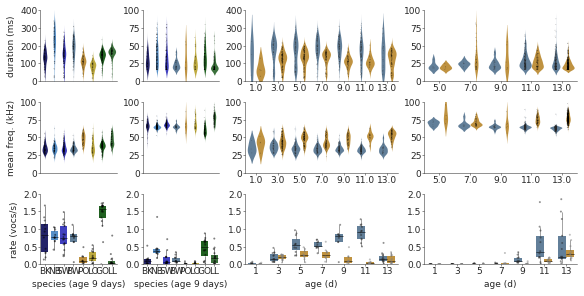

In [41]:
save = False
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'
version = '20230130_v0'

###################################################################################################################

order = ['BK', 'NB', 'SW', 'BW', 'PO', 'LO', 'GO', 'LL']

fontsize = 9
ytick_length = 2
ytick_pad = 0.5

rate_dots_jitter = 0.1
rate_dots_size = 2
rate_dots_alpha = 0.5

feature_dots_jitter = 0.05
feature_dots_size = 1
feature_dots_alpha = .25

###################################################################################################################

#get ages
cry_df = ds_df.loc[ds_df['human_label'] == 'cry']
USV_df = ds_df.loc[ds_df['human_label'] == 'USV']

sns.set(style="ticks", color_codes=True)
fig, axes = plt.subplot_mosaic(mosaic="ACBBDD;EGFFHH;IKJJLL", 
                               figsize=[8,4], constrained_layout=True)

# # get the colors
# colors = pd.Series(data['species'].unique()).map(species_color_dict)

#define the colors
species_color_dict = {'BW':'steelblue',
                      'NB': 'dodgerblue',
                      'BK': 'darkblue',
                      'SW': 'blue',
                      'PO': 'orange',
                      'LO': 'gold',
                      'GO': 'green',
                      'LL': 'forestgreen',
                      'MU': 'mediumspringgreen', 
                      'MZ': 'turquoise'}


# to iterate through
features_to_plot = ['duration', 'meanfreq']
cry_axes = ['A', 'E']
whis_axes = ['C', 'G']

#plot the cry acoustic features_to_plot at p9
for cry_axis, feature in zip(cry_axes, features_to_plot):
    
    data = cry_df.loc[cry_df['age'] == 9]

    #cry dots
    box = sns.stripplot(ax=axes[cry_axis], 
          data=data,
          x='species',
          jitter=feature_dots_jitter,
          y= feature, 
          color='black', 
          order=order, 
          dodge=True, 
          s=feature_dots_size, 
          alpha = feature_dots_alpha)

    #cry boxes
    box = sns.violinplot(ax=axes[cry_axis], 
                data=data,
                x='species', 
                y=feature, 
                order=order, 
                linewidth=0, 
                palette=species_color_dict, 
                saturation=.5, 
                inner='quartile')

    #prettify
    box.legend([],[], frameon=False)
    if feature == 'duration':
        axes[cry_axis].set_ylabel(ylabel = 'duration (ms)', fontsize = fontsize)
    elif feature == 'meanfreq':
        axes[cry_axis].set_ylabel(ylabel = 'mean freq. (kHz)', fontsize = fontsize)
    for axis in ['top','bottom','left','right']:
        axes[cry_axis].spines[axis].set_linewidth(.5)
        
    for label in (axes[cry_axis].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    axes[cry_axis].set_xticks([], [])
    
    axes[cry_axis].get_xaxis().set_visible(False)
    axes[cry_axis].yaxis.set_tick_params(width=.5, rotation = 0, length=ytick_length, pad = ytick_pad)
    axes[cry_axis].xaxis.set_tick_params(width=.5, rotation = 0, length=ytick_length, pad = ytick_pad)
    if feature == 'meanfreq':
        axes[cry_axis].set_ylim([0,100])
        axes[cry_axis].set_yticks([0,25,50,75,100])
    if feature == 'duration':
        axes[cry_axis].set_ylim([0,400])
        axes[cry_axis].set_yticks([0,100,200,300,400])
    sns.despine()
        
# plot the USV acoustic features_to_plot at p9
for USV_axis, feature in zip(whis_axes, features_to_plot):
        
    data = USV_df.loc[USV_df['age'] == 9]

    #USV boxes
    box = sns.violinplot(ax=axes[USV_axis], 
                data=data,
                x='species', 
                y=feature, 
                order=order, 
                linewidth=0, 
                palette=species_color_dict, 
                saturation=.5, 
                inner='quartile')

    #USV dots
    box = sns.stripplot(ax=axes[USV_axis], 
          data=data,
          x='species', 
          jitter=feature_dots_jitter,
          y=feature, 
          color='black', 
          order=order, 
          dodge=True, 
          s=feature_dots_size, 
          alpha = feature_dots_alpha)

    #prettify
    box.legend([],[], frameon=False)
    axes[USV_axis].set_ylabel('')
    
    for axis in ['top','bottom','left','right']:
        axes[USV_axis].spines[axis].set_linewidth(.5)
        
    for label in (axes[USV_axis].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    axes[USV_axis].set_xticks([], [])
    axes[USV_axis].get_xaxis().set_visible(False)
    axes[USV_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].set_yticks([0,25,50,75,100])
    if feature == 'meanfreq':
        axes[USV_axis].set_ylim([0,100])
    if feature == 'duration':
        axes[USV_axis].set_ylim([0,100])
    sns.despine()
        
#plot the cry rates at p9
cry_axes = ['I']
whis_axes = ['K']
feeatures = ['_per_sec']

for cry_axis in cry_axes:
    
    data = all_pups.loc[all_pups['age'] == 9]

    #cry dots
    box = sns.stripplot(ax=axes[cry_axis], 
          data=data,
          jitter = rate_dots_jitter,
          x='species', 
          y= 'cry_per_sec', 
          color='black', 
          order=order, 
          dodge=True, 
          s=rate_dots_size, 
          alpha = rate_dots_alpha)

    #cry boxes
    box = sns.boxplot(ax=axes[cry_axis], 
                data=data,
                x='species', 
                y='cry_per_sec', 
                order=order, 
                linewidth=.5, 
                palette=species_color_dict, 
                saturation=.5, 
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)

    #prettify
    box.legend([],[], frameon=False)
    axes[cry_axis].set_ylabel(ylabel = 'rate (vocs/s)', fontsize=fontsize)
    axes[cry_axis].set_xlabel(xlabel = 'species (age 9 days)', fontsize=fontsize)
    axes[cry_axis].set_yticks([0,.5,1,1.5,2])
    for axis in ['top','bottom','left','right']:
        axes[cry_axis].spines[axis].set_linewidth(.5)
    for label in (axes[cry_axis].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
    for label in (axes[cry_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    axes[cry_axis].set_yticks([0,0.5,1,1.5, 2])
    axes[cry_axis].yaxis.set_tick_params(length = ytick_length, width=.5, rotation = 0, pad=ytick_pad)
    axes[cry_axis].xaxis.set_tick_params(length = ytick_length, width=.5, rotation = 0, pad=ytick_pad)
    axes[cry_axis].set_ylim([0,2])
    sns.despine()
       
        
#plot the USV rates at p9        
for USV_axis in whis_axes:
        
    data = all_pups.loc[all_pups['age'] == 9]

    #USV boxes
    box = sns.boxplot(ax=axes[USV_axis], 
                data=data,
                x='species', 
                y='USV_per_sec', 
                order=order, 
                linewidth=.5, 
                palette=species_color_dict, 
                saturation=.5, 
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)

    #USV dots
    box = sns.stripplot(ax=axes[USV_axis], 
          data=data,
          jitter = rate_dots_jitter,
          x='species', 
          y='USV_per_sec',
          color='black', 
          order=order, 
          dodge=True, 
          s=rate_dots_size, 
          alpha = rate_dots_alpha)

    #prettify
    box.legend([],[], frameon=False)
    axes[USV_axis].set_ylabel('')
    axes[USV_axis].set_xlabel(xlabel = 'species (age 9 days)', fontsize=fontsize)
    axes[USV_axis].set_yticks([0,.5,1,1.5,2])
    for axis in ['top','bottom','left','right']:
        axes[USV_axis].spines[axis].set_linewidth(.5)
    for label in (axes[USV_axis].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
    for label in (axes[USV_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    #axes[USV_axis].set_xticks([], [])
    axes[USV_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].set_ylim([0,2])
    sns.despine()


#add time courses    
bwpo_cry_axes = ['B', 'F', 'J']
bwpo_USV_axes = ['D', 'H', 'L']

recording_length_s = 600

#get data for BW and PO
cry_bwpo_df = cry_df.loc[(cry_df['species'] == 'BW' ) | (cry_df['species'] == 'PO' )]
USV_bwpo_df = USV_df.loc[(USV_df['species'] == 'BW' ) | (USV_df['species'] == 'PO' )]

#plot the BW_PO time course for the cry acoustic features_to_plot
for cry_axis, feature in zip(bwpo_cry_axes, features_to_plot):
    #cry dots
    
    data = cry_bwpo_df
    
    box = sns.stripplot(ax=axes[cry_axis], 
          data=data,
          jitter=feature_dots_jitter,
          x='age', 
          y=feature, 
          hue='species', 
          color='black', 
          dodge=True, 
          s=feature_dots_size, 
          alpha = feature_dots_alpha)

    #cry boxes
    box = sns.violinplot(ax=axes[cry_axis], 
                data=data,
                x='age', 
                y=feature, 
                dodge=True, 
                hue='species',
                linewidth=0, 
                palette=species_color_dict, 
                saturation=.5, 
                inner='quartile')

    #prettify
    box.legend([],[], frameon=False)
    axes[cry_axis].set_ylabel('')
    axes[cry_axis].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        axes[cry_axis].spines[axis].set_linewidth(.5)
    for label in (axes[cry_axis].get_yticklabels()+axes[cry_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    #axes[cry_axis].set_xticks([], [])
    axes[cry_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[cry_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    if feature == 'meanfreq':
        axes[cry_axis].set_ylim([0,100])
        axes[cry_axis].set_yticks([0,25,50,75,100])
    if feature == 'duration':
        axes[cry_axis].set_ylim([0,400])
        axes[cry_axis].set_yticks([0,100,200,300,400])
    sns.despine()

#plot the BW_PO time course for the USV acoustic features_to_plot       
for USV_axis, feature in zip(bwpo_USV_axes, features_to_plot):
    
    data = USV_bwpo_df.loc[~USV_bwpo_df['age'].isin([1, 3])] #drop ages where PO makes no wbistls
    
    #USV dots
    box = sns.stripplot(ax=axes[USV_axis], 
          data=data,
          jitter=feature_dots_jitter,
          x='age', 
          y=feature, 
          hue='species', 
          color='black', 
          dodge=True, 
          s=feature_dots_size, 
          alpha = feature_dots_alpha)

    #USV boxes
    box = sns.violinplot(ax=axes[USV_axis], 
                      data=data,
                      x='age', 
                      y=feature,  
                      dodge=True, 
                      hue='species',
                      linewidth=0, 
                      palette=species_color_dict, 
                      saturation=.5, 
                      inner='quartile')

    #prettify
    box.legend([],[], frameon=False)
    axes[USV_axis].set_ylabel('')
    axes[USV_axis].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        axes[USV_axis].spines[axis].set_linewidth(.5)
    for label in (axes[USV_axis].get_yticklabels() + axes[USV_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    #axes[USV_axis].set_xticks([], [])
    axes[USV_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].set_yticks([0,25,50,75,100])
    if feature == 'meanfreq':
        axes[USV_axis].set_ylim([0,100])
    if feature == 'duration':
        axes[USV_axis].set_ylim([0,100])
    sns.despine()
    
#plot the rates for the BW PO time course 
bwpo_cry_axes = ['J']
bwpo_USV_axes = ['L']

#get data for BW and PO
bwpo_df = all_pups.loc[(all_pups['species'] == 'BW' ) | (all_pups['species'] == 'PO' )]
colors = bwpo_df['species'].map(species_color_dict)

#plot the rates for the BW PO time course cries
for cry_axis in bwpo_cry_axes:
    #cry dots
    
    data = bwpo_df
    
    #cry dots
    box = sns.stripplot(ax=axes[cry_axis], 
          data=data,
          jitter = rate_dots_jitter,
          x='age', 
          y='cry_per_sec', 
          hue='species', 
          color='grey', 
          dodge=True, 
          s=rate_dots_size, 
          alpha = rate_dots_alpha)


    #cry boxes
    box = sns.boxplot(ax=axes[cry_axis], 
                data=data,
                x='age', 
                y='cry_per_sec', 
                dodge=True, 
                hue='species',
                linewidth=.5, 
                palette=species_color_dict, 
                saturation=.5,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .00001}, 
                width = .75, 
                showcaps=False)

    #prettify
    box.legend([],[], frameon=False)
    axes[cry_axis].set_ylabel('')
    axes[cry_axis].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    for axis in ['top','bottom','left','right']:
        axes[cry_axis].spines[axis].set_linewidth(.5)
    for label in (axes[cry_axis].get_yticklabels() + axes[cry_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
    
    axes[cry_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[cry_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[cry_axis].set_yticks([0,.5,1,1.5,2])
    axes[cry_axis].spines.bottom.set_visible(False)
    axes[cry_axis].set_ylim([0,2])
    sns.despine()
        
        
#plot the rates for the BW PO time course USVs
for USV_axis, feature in zip(bwpo_USV_axes, features_to_plot):
    
    data = bwpo_df
    
    #USV dots
    box = sns.stripplot(ax=axes[USV_axis], 
          data=data,
          jitter = rate_dots_jitter,
          x='age', 
          y='USV_per_sec', 
          hue='species', 
          color='grey', 
          dodge=True, 
          s=rate_dots_size, 
          alpha = rate_dots_alpha)

    #USV boxes
    box = sns.boxplot(ax=axes[USV_axis], 
                      data=data,
                      x='age', 
                      y='USV_per_sec',  
                      dodge=True, 
                      hue='species',
                      linewidth=.5, 
                      palette=species_color_dict, 
                      saturation=.5, 
                      whis=1.5, 
                      showfliers = False, 
                      flierprops={"marker": ""},
                      medianprops={"color": "black"},
                      boxprops={"linewidth": .00001}, 
                      width = .75, 
                      showcaps=False)
    

    #prettify
    box.legend([],[], frameon=False)
    axes[USV_axis].set_ylabel('')
    axes[USV_axis].set_xlabel(xlabel = 'age (d)', fontsize=fontsize)
    for axis in ['top','bottom','left','right']:
        axes[USV_axis].spines[axis].set_linewidth(.5)
    for label in (axes[USV_axis].get_yticklabels() + axes[USV_axis].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    axes[USV_axis].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    axes[USV_axis].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    axes[USV_axis].spines.bottom.set_visible(False)
    #axes[USV_axis].set_xticks([], [])
    axes[USV_axis].set_yticks([0,.5,1,1.5,2])
    axes[USV_axis].set_ylim([0,2])
    sns.despine()
    
# if save == True:
#     save_name = ('_').join(['features_to_plot_violin', version])
#     plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
#     plt.savefig(os.path.join(save_dir, save_name)+'.pdf')


## PCA on features of annotated vocalizations (Supplemental Figure 2)

### collect annotations and downsample

In [26]:
#collect the annotations

species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']
annotated_files = []

for species in species_list:
    print(species)
    
    #get the label_0 files
    label_0_voc_path = os.path.join(annotations_root,species,'annotations','hdbscan_label_0',species+'_hdbscan_label0_all.feather')
    
    #load the data
    label_0_voc_df = pd.read_feather(label_0_voc_path)
    
    #drop the spectrogram pixels and append
    label_0_voc_df = label_0_voc_df[['source_file', 'umap1', 'umap2', 'hdbscan_label', 'human_label']]
    annotated_files.append(label_0_voc_df)

    #get the label_1 files 
    label_1_voc_path = os.path.join(annotations_root,species,'annotations','hdbscan_label_1',species+'_hdbscan_label1_all.feather')
    
    #load the data
    label_1_voc_df = pd.read_feather(label_1_voc_path)
    
    #drop the spectrogram pixels and append
    label_1_voc_df = label_1_voc_df[['source_file', 'umap1', 'umap2', 'hdbscan_label', 'human_label']]
    annotated_files.append(label_1_voc_df)

#combine the annotations and remove the non-vocal sounds
print('combining files...')
all_combined = pd.concat(annotated_files)
all_combined['species'] = [i.split('_')[0] for i in all_combined['source_file']]
all_combined = all_combined.loc[~all_combined['human_label'].isin(['scratch', 'none'])]
all_combined = all_combined.reset_index(drop=True)
all_combined['human_label'] = ['USV' if i=='whistle' else i for i in all_combined['human_label']]

print('done.')
    


BW
BK
NB
SW
PO
LO
GO
LL
combining files...
done.


In [27]:
# merge with acoustic features

#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#merge keeping only source files that have been annotated
print('merging...')
annotated_df = features_df.merge(all_combined, how='right',on='source_file').reset_index(drop=True)
assert(annotated_df['species_x'].equals(annotated_df['species_y']))
annotated_df = annotated_df.rename(columns={'species_x':'species'}).drop(columns=['species_y'])
annotated_df['pup'] = [i.split('_clip')[0] for i in annotated_df['source_file']]

#add columns for useful info from file names
annotated_df['litter'] = [i.split('_')[1]+'_'+i.split('_')[-2] for i in annotated_df['pup']]
annotated_df['voc_number'] = [int(i.split('_')[-1].split('.')[0]) for i in annotated_df['source_file']]
annotated_df['sex'] = [i.split('_')[6] for i in annotated_df['pup']]
annotated_df['weight_mg'] = [float(i.split('_')[5]) for i in annotated_df['source_file']]
annotated_df['age'] = [float(i.split('_')[-5][1:]) if not i.split('_')[-5] == 'nan' else float('NaN') for i in annotated_df['source_file']]
annotated_df['removal_flag'] = [float(i.split('_')[-6][-1]) if not i.split('_')[-6] == 'nan' else float('NaN') for i in annotated_df['source_file']]
annotated_df['duration'] = [i*1000 for i in annotated_df['duration']]
print('done.')

getting features...
merging...
done.


In [28]:
# print the total number of annotations for each species and label
print('total label counts:\n\t')
print('cry:', len(annotated_df.loc[annotated_df['human_label'] == 'cry']))
print('USV:', len(annotated_df.loc[annotated_df['human_label'] == 'USV']))
print('scratch:', len(annotated_df.loc[annotated_df['human_label'] == 'scratch']))

print('\n')
for species in species_list:
    print(species)
    print('\tcry:', len(annotated_df.loc[annotated_df['human_label'] == 'cry'].loc[annotated_df['species'] == species]))
    print('\tUSV:', len(annotated_df.loc[annotated_df['human_label'] == 'USV'].loc[annotated_df['species'] == species]))
    print('\tscratch:', len(annotated_df.loc[annotated_df['human_label'] == 'scratch'].loc[annotated_df['species'] == species]))
          

total label counts:
	
cry: 18743
USV: 39542
scratch: 0


BW
	cry: 2367
	USV: 6865
	scratch: 0
BK
	cry: 2625
	USV: 5369
	scratch: 0
NB
	cry: 2271
	USV: 4916
	scratch: 0
SW
	cry: 2412
	USV: 4304
	scratch: 0
PO
	cry: 2599
	USV: 3065
	scratch: 0
LO
	cry: 2038
	USV: 2339
	scratch: 0
GO
	cry: 2339
	USV: 6660
	scratch: 0
LL
	cry: 2092
	USV: 6024
	scratch: 0


In [29]:
#make sure there are no bad pups with corrupted audio

#bad pups are those with a lot fo artefacts (big vertical lines) identified during annotations for das
bad_pups = ['NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13',
            'SW_29542x30031_ltr1_pup7_ch8_1600_m_348_263_fr0_p1_2022-01-05_10-54-58',
            'BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
            'BK_26464x25680_ltr3_pup4_ch5_5100_m_351_326_fr0_p7_2021-10-31_11-18-39',
            'GO_24860x23748_ltr2_pup4_ch5_4700_m_324_292_fr0_p9_2021-10-02_12-35-01',
            'GO_23883x23084_ltr2_pup4_ch6_6100_f_329_304_fr0_p11_2019-12-03_10-35-37']

#drop them
annotated_df['pup'] = [i.split('_clip')[0] for i in annotated_df['source_file']]
print('dropping', len(annotated_df.loc[annotated_df['pup'].isin(bad_pups)]), 'vocs because they come from bad recordings...')
annotated_df = annotated_df.loc[~annotated_df['pup'].isin(bad_pups)]
assert len(annotated_df.loc[annotated_df['pup'].isin(bad_pups)]) == 0
print('done.')

dropping 110 vocs because they come from bad recordings...
done.


In [30]:
#sample vocalizations 

seed = 123456
num_to_sample = 500
downsampled_list = []

# #drop pups that don't have weight info
annotated_df = annotated_df.loc[annotated_df['weight_mg'] != 'nan']

for species in species_list:

    #get the voc types for this label
    temp_cry = annotated_df.loc[annotated_df['species'] == species].loc[annotated_df['human_label'] == 'cry']
    temp_USV = annotated_df.loc[annotated_df['species'] == species].loc[annotated_df['human_label'] == 'USV']
   
    #sample
    temp_cry = temp_cry.sample(n=num_to_sample, random_state = seed)
    temp_USV = temp_USV.sample(n=num_to_sample, random_state = seed)
    
    #reasemble
    downsampled_species = pd.concat([temp_cry, temp_USV])

    #update downsampled_list
    downsampled_list.append(downsampled_species)
    
#assemble all the species
ds_df = pd.concat(downsampled_list)
ds_df = ds_df.reset_index(drop=True)

#show some useful info
print('annotations by species:\n')
for i in species_list:
    print(i,':', len(ds_df.loc[ds_df['species'] == i]))
    
print('annotations by label:\n')
print('cry:', len(ds_df.loc[ds_df['human_label'] == 'cry']))
print('USV:', len(ds_df.loc[ds_df['human_label'] == 'USV']))
print('scratch:', len(ds_df.loc[ds_df['human_label'] == 'scratch']))


annotations by species:

BW : 1000
BK : 1000
NB : 1000
SW : 1000
PO : 1000
LO : 1000
GO : 1000
LL : 1000
annotations by label:

cry: 4000
USV: 4000
scratch: 0


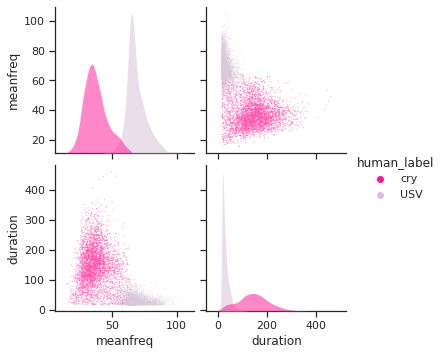

In [32]:
#look at pair plot to check for outliers
to_plot = ds_df[['meanfreq', 'duration', 'human_label']]

voc_name_color_dict = {'cry': 'deeppink', 
               'USV': 'thistle', 
               'nan':'black'}

sns.pairplot(data = to_plot, 
             hue = 'human_label', 
             palette = voc_name_color_dict, 
             corner = False, 
             plot_kws = {'s':1, 'alpha':.5},
             diag_kws = {'linewidth': 0.01, 'alpha':.5}
            )

In [51]:
#separate cries and USVs for separate PCAs
cry_df = ds_df.loc[ds_df['human_label'] == 'cry']
USV_df = ds_df.loc[ds_df['human_label'] == 'USV']

assert set(cry_df['human_label'].unique())== set(['cry'])
assert set(USV_df['human_label'].unique()) == set(['USV'])

In [52]:
#get the features for PCA that are "biologically interesting", ie that we might be able to map genetically
biologically_interesting_features = ['duration', 
                                     'dfslope', 
                                     'time.median', 
                                     'time.IQR', 
                                     'time.Q25', 
                                     'time.Q75', 
                                     'meanfreq', 
                                     'meandom', 
                                     'freq.IQR', 
                                     'freq.Q25', 
                                     'freq.Q75', 
                                     'freq.median', 
                                     'sp.ent', 
                                     'time.ent']
cry_df_pca = cry_df[biologically_interesting_features]
USV_df_pca = USV_df[biologically_interesting_features]

# #log scale for outliers
# cry_df_pca = np.log2(cry_df_pca + 1e-12)
# whistle_df_pca = np.log2(whistle_df_pca + 1e-12) #1e-12 filler to avoid -inf result

# #replace nans with 0
# cry_df_pca = cry_df_pca.fillna(0)
# whistle_df_pca = whistle_df_pca.fillna(0)

### do the pca

In [54]:
# PCA

n_components = 3

#########################################################################################################

# Standardize the cry features
cry_sf = StandardScaler().fit_transform(cry_df_pca)

# Standardize the USV features
USV_sf = StandardScaler().fit_transform(USV_df_pca)

#cry PCA
print('doing PCA on cry features...')
cry_pca = PCA(n_components = n_components)
cry_pca_embedding = cry_pca.fit_transform(cry_sf)
print('\tdone.')
print('\texplained variance by PC:', cry_pca.explained_variance_ratio_)
print('\ttotal variance explained:', sum(cry_pca.explained_variance_ratio_))

#add for plotting
cry_df['pc1'] = cry_pca_embedding[:,0]
cry_df['pc2'] = cry_pca_embedding[:,1]
cry_df['pc3'] = cry_pca_embedding[:,2]

print('getting loadings for cry pcs...')
cry_loadings = pd.DataFrame(cry_pca.components_.T, columns=['pc1', 'pc2', 'pc3'], index=cry_df_pca.columns)
cry_loadings['pc1'] = np.abs(cry_loadings['pc1'])
cry_loadings['pc2'] = np.abs(cry_loadings['pc2'])
cry_loadings['pc3'] = np.abs(cry_loadings['pc3'])
cry_loadings['feature'] = cry_loadings.index
cry_loadings_pc1 = pd.DataFrame(cry_loadings.sort_values(by = ['pc1'], ascending=False))
cry_loadings_pc2 = pd.DataFrame(cry_loadings.sort_values(by = ['pc2'], ascending=False))
cry_loadings_pc3 = pd.DataFrame(cry_loadings.sort_values(by = ['pc3'], ascending=False))
print('\tdone.')


#USV PCA
print('doing PCA on USV features...')
USV_pca = PCA(n_components = n_components)
USV_pca_embedding = USV_pca.fit_transform(USV_sf)
print('\tdone.')
print('\texplained variance by PC:', USV_pca.explained_variance_ratio_)
print('\ttotal variance explained:', sum(USV_pca.explained_variance_ratio_))

#add for plotting
USV_df['pc1'] = USV_pca_embedding[:,0]
USV_df['pc2'] = USV_pca_embedding[:,1]
USV_df['pc3'] = USV_pca_embedding[:,2]

print('getting loadings for USV pcs...')
USV_loadings = pd.DataFrame(USV_pca.components_.T, 
                                columns=['pc1', 'pc2', 'pc3'], 
                                index=USV_df_pca.columns)

USV_loadings['pc1'] = np.abs(USV_loadings['pc1'])
USV_loadings['pc2'] = np.abs(USV_loadings['pc2'])
USV_loadings['pc3'] = np.abs(USV_loadings['pc3'])
USV_loadings['feature'] = USV_loadings.index
USV_loadings_pc1 = pd.DataFrame(USV_loadings.sort_values(by = ['pc1'], ascending=False))
USV_loadings_pc2 = pd.DataFrame(USV_loadings.sort_values(by = ['pc2'], ascending=False))
USV_loadings_pc3 = pd.DataFrame(USV_loadings.sort_values(by = ['pc3'], ascending=False))
print('\tdone.')

doing PCA on cry features...
	done.
	explained variance by PC: [0.35456017 0.29384233 0.12641788]
	total variance explained: 0.7748203805336673
getting loadings for cry pcs...
	done.
doing PCA on USV features...
	done.
	explained variance by PC: [0.39833134 0.2653894  0.16602672]
	total variance explained: 0.8297474650707025
getting loadings for USV pcs...
	done.


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

### plot the figure

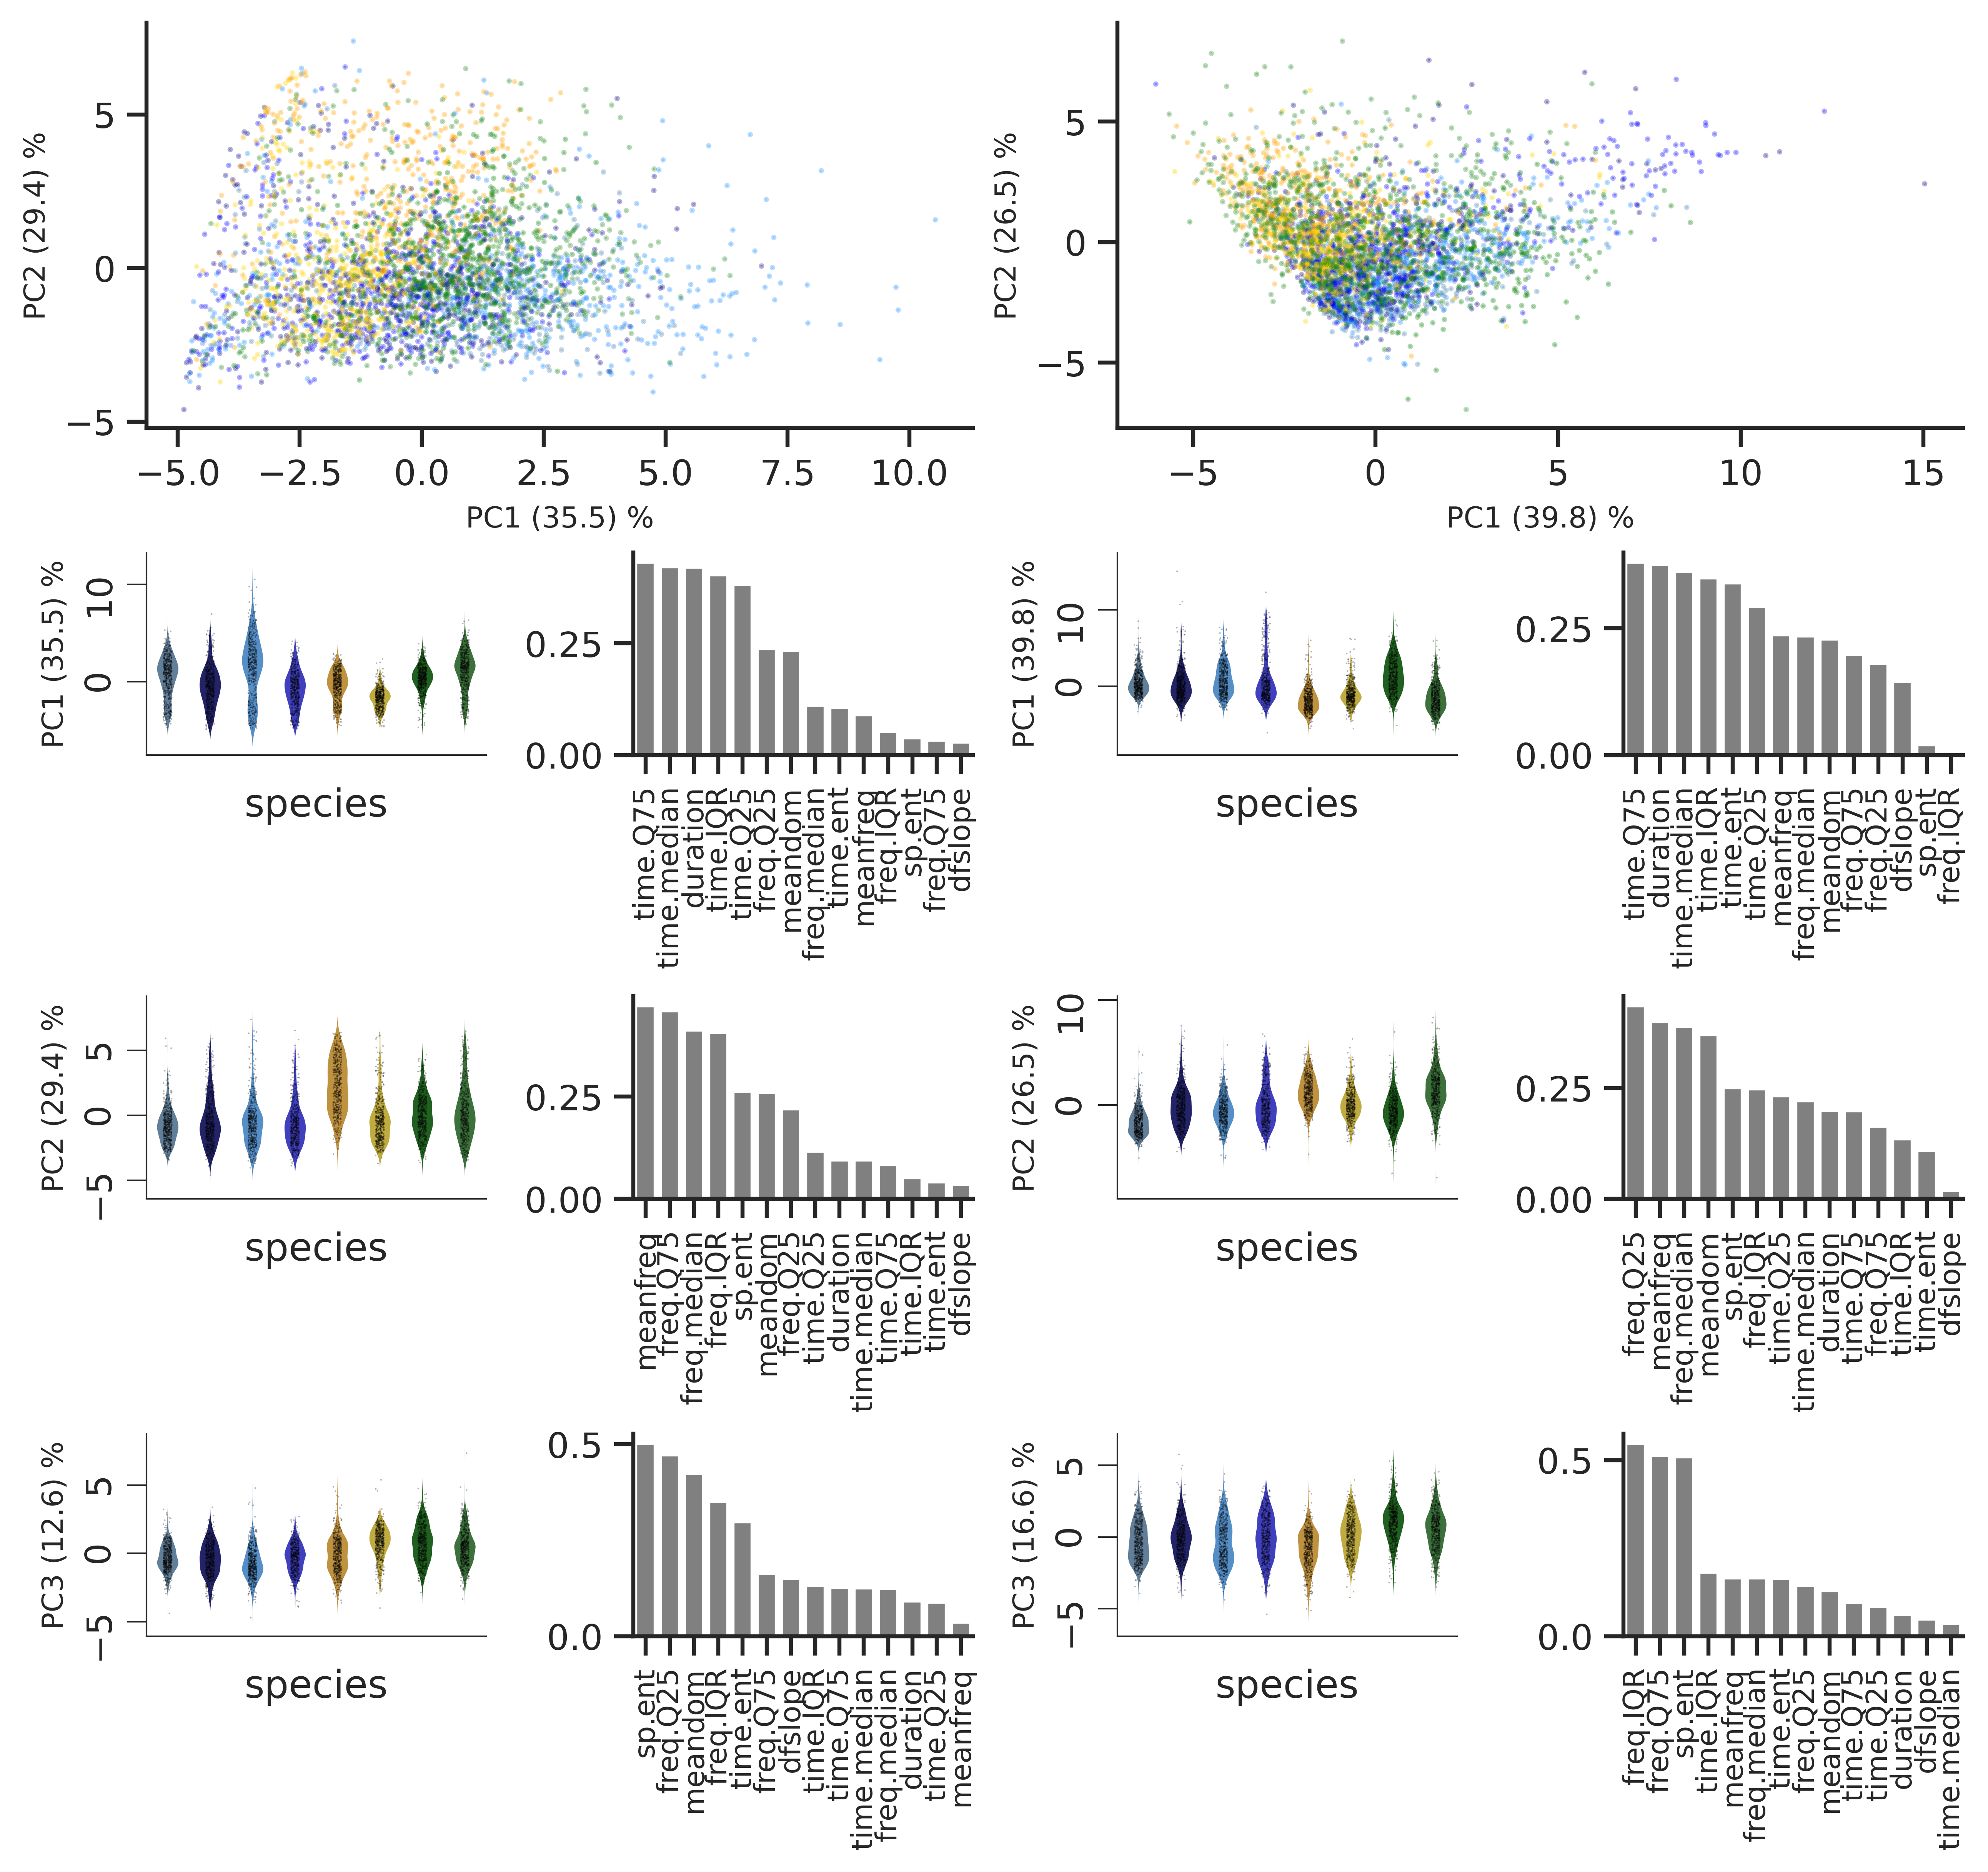

In [68]:

save= False
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/supplement/'


fig, axes = plt.subplot_mosaic(mosaic = "AAAABBBB;AAAABBBB;IIWWJJXX;KKYYLLZZ;MMEENNFF", 
                            figsize=[8.5,8], 
                            constrained_layout=True, 
                            dpi=600)

violin_dot_size = .5
violin_alpha = .3
fontsize = 9

#plot cry PCS
cry_pc_violin_axes = ["I", "K", "M"]
pcs = ['pc1', 'pc2', 'pc3']
for ax, pc in zip(cry_pc_violin_axes, pcs):
    data = cry_df

    swarm_plot = sns.stripplot(x='species', 
                               y=pc, 
                               data=data, 
                               alpha = violin_alpha, 
                               size=violin_dot_size, 
                               jitter = True,  
                               color = 'black', 
                               dodge = False, 
                               ax = axes[ax])

    swarm_plot = sns.violinplot(x='species', 
                             y=pc,
                             showcaps=False,
                             saturation=0.5,
                             data=data,
                             width = .5, 
                             linewidth = 0, 
                             inner=None,
                             dodge = False, 
                             palette = species_color_dict,
                             hue = 'species',  
                             ax = axes[ax])

    swarm_plot.legend([],[], frameon=False)
    
    if pc == 'pc1':
        axes[ax].set_ylabel("PC1 ("+str(round(cry_pca.explained_variance_ratio_[0], 3)*100)+") %", fontsize=9)
    elif pc == 'pc2':
        axes[ax].set_ylabel("PC2 ("+str(round(cry_pca.explained_variance_ratio_[1], 3)*100)+") %", fontsize=9)
    elif pc == 'pc3':
        axes[ax].set_ylabel("PC3 ("+str(round(cry_pca.explained_variance_ratio_[2], 3)*100)+") %", fontsize=9)
    
    for axis in ['top','bottom','left','right']:
        axes[ax].spines[axis].set_linewidth(.5)
        
    axes[ax].set_xticks([],[])  
    axes[ax].xaxis.set_tick_params(width=.5, rotation = 90)
    axes[ax].yaxis.set_tick_params(width=.5, rotation = 90)
    sns.despine()
    
#plot USV PCS
USV_pc_violin_axes = ["J", "L", "N"]
pcs = ['pc1', 'pc2', 'pc3']
for ax, pc in zip(USV_pc_violin_axes, pcs):
    data = USV_df

    swarm_plot = sns.stripplot(x='species', 
                               y=pc, 
                               data=data, 
                               alpha = violin_alpha, 
                               size= violin_dot_size, 
                               jitter = True,  
                               color = 'black', 
                               dodge = False, 
                               ax = axes[ax])

    swarm_plot = sns.violinplot(x='species', 
                             y=pc,
                             showcaps=False,
                             saturation=0.5,
                             data=data,
                             width = .5, 
                             linewidth = 0, 
                             inner=None,
                             dodge = False, 
                             palette = species_color_dict,
                             hue = 'species',  
                             ax = axes[ax])
    
    if pc == 'pc1':
        axes[ax].set_ylabel("PC1 ("+str(round(USV_pca.explained_variance_ratio_[0], 3)*100)[:4]+") %", fontsize=9)
    elif pc == 'pc2':
        axes[ax].set_ylabel("PC2 ("+str(round(USV_pca.explained_variance_ratio_[1], 3)*100)+") %", fontsize=9)
    elif pc == 'pc3':
        axes[ax].set_ylabel("PC3 ("+str(round(USV_pca.explained_variance_ratio_[2], 3)*100)+") %", fontsize=9)

    swarm_plot.legend([],[], frameon=False)
    for axis in ['top','bottom','left','right']:
        axes[ax].spines[axis].set_linewidth(.5)

    axes[ax].set_xticks([],[])    
    axes[ax].yaxis.set_tick_params(width=.5, rotation = 90)
    sns.despine()
    
    
# plot loadings for cries

cry_loadings_axes = ["W", "Y", "E"]
cry_pc_dfs = [cry_loadings_pc1, cry_loadings_pc2, cry_loadings_pc3]
pcs = ['pc1', 'pc2', 'pc3']

for ax,df,pc in zip(cry_loadings_axes, cry_pc_dfs, pcs):
    sns.barplot(ax = axes[ax], 
                x =df['feature'], 
                y=df[pc], 
                color = 'grey')
    
    axes[ax].set_xticks(ticks = range(len(df.index)), labels = df.index, rotation=90, fontsize=9)
    axes[ax].set_xlabel('')
    axes[ax].set_ylabel('')

#plot loadings for USVs
USV_loadings_axes = ["X", "Z", "F"]
USV_pc_dfs = [USV_loadings_pc1, USV_loadings_pc2, USV_loadings_pc3]
pcs = ['pc1', 'pc2', 'pc3']

for ax,df,pc in zip(USV_loadings_axes, USV_pc_dfs, pcs):
    sns.barplot(ax = axes[ax], 
                x =df['feature'], 
                y=df[pc], 
                color = 'grey')
    
    axes[ax].set_xticks(ticks = range(len(df.index)), labels = df.index, rotation=90, fontsize=9)
    axes[ax].set_xlabel('')
    axes[ax].set_ylabel('')
    
    
#plot cry PCA scatter
axes["A"].scatter(x=cry_df["pc1"], 
                  y=cry_df["pc2"], 
                  c=cry_df['species'].map(species_color_dict), 
                  s = violin_dot_size, 
                  alpha = violin_alpha
)
axes["B"].scatter(x=USV_df["pc1"], 
                  y=USV_df["pc2"], 
                  c=USV_df['species'].map(species_color_dict),
                  s = violin_dot_size, 
                  alpha = violin_alpha
)
plt.xticks(fontsize=9, rotation=90)
axes["A"].set_xlabel("PC1 ("+str(round(cry_pca.explained_variance_ratio_[0], 3)*100)+") %", fontsize=9)
axes["A"].set_ylabel("PC2 ("+str(round(cry_pca.explained_variance_ratio_[1], 3)*100)+") %", fontsize=9)
axes["B"].set_xlabel("PC1 ("+str(round(USV_pca.explained_variance_ratio_[0], 3)*100)[:4]+") %", fontsize=9)
axes["B"].set_ylabel("PC2 ("+str(round(USV_pca.explained_variance_ratio_[1], 3)*100)+") %", fontsize=9)

if save:
    save_name = '20230130_Figure_2_supplement_1.jpeg'
    plt.savefig(os.path.join(save_dir,save_name), dpi=600)
    
    save_name = '20230130_Figure_2_supplement_1.svg'
    plt.savefig(os.path.join(save_dir,save_name))
    

# Figure 4 (cross foster experiments)

## collect the raw data

In [136]:
#paths for the directory containing warbleR features for each dataset
development_features_dir = os.path.join(acoustic_features_root, 'development','20220913_063001')
cf_features_dir = os.path.join(acoustic_features_root, 'bw_po_cf','20220926_072033')

In [137]:
#combine features across conditions into a single dataframe

#these are the files to combine
feature_files = ['BWwarbler_features.csv', 
                 'POwarbler_features.csv', 
                 'CF-BWwarbler_features.csv', 
                 'CF-POwarbler_features.csv']

#combine them
all_combined = []
for file in [i for i in glob.glob(os.path.join(cf_features_dir,'*.csv')) if i.split('/')[-1] in feature_files]:
    temp = pd.read_csv(file)
    all_combined.append(temp)
    
#add useful information
bw_po_cf_features = pd.concat(all_combined)
bw_po_cf_features['species'] = [i.split('_')[0] for i in bw_po_cf_features['source_file']]
bw_po_cf_features['dataset'] = dataset
bw_po_cf_features['segmentation_iteration'] = directory.split('/')[-1]
bw_po_cf_features['pup'] = [i.split('_clip')[0] for i in bw_po_cf_features['source_file']]
bw_po_cf_features = bw_po_cf_features.reset_index(drop=True)
print('duplicates:', bw_po_cf_features.duplicated().sum())

#check for NaNs and drop those vocalizations
print('there are', len(bw_po_cf_features[bw_po_cf_features.isna().any(axis=1)]), 'rows with nan values.')
print('dropping these rows...')
bw_po_cf_features = bw_po_cf_features.dropna(axis=0,how='any')

print('done.')

duplicates: 0
there are 2 rows with nan values.
dropping these rows...
done.


## predict vocalization type

In [138]:
#choose the dataset to process --- this is the only line you need to change to label a new dataset
dataset = 'bw_po_cf'

#get the model
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
model_params = parameters.load_parameters(save_dir=os.path.split(voc_type_params_path)[0], save_name=os.path.split(voc_type_params_path)[1])

print('predicting', dataset, 'vocalizations')
df = bw_po_cf_features

#make sure NaNs are dropped (can't predict labels from them)
assert len(df[df.isna().any(axis=1)]) == 0

#check for duplicates (there should be none)
assert df.duplicated().sum() == 0

#get the features needed to predict vocalization type
for_prediction = df[model_params['feature_set']]

#predict vocalization types - takes about 10 minutes 
print('predicting vocalization labels...')
predicted_labels = voc_type_model.predict(for_prediction)
assert set(predicted_labels) == set(['cry', 'scratch', 'whistle'])
assert len(predicted_labels) == len(df)

#give some info
print("total predicted 'cry':", len([i for i in predicted_labels if i=='cry']))
print("total predicted 'whistle':", len([i for i in predicted_labels if i=='whistle']))
print("total predicted 'scratch':", len([i for i in predicted_labels if i=='scratch']))

#add to the dataframe
bw_po_cf_features['predicted_label'] = predicted_labels

#drop the non-vocal sound
bw_po_cf_features = bw_po_cf_features.loc[bw_po_cf_features['predicted_label'] != 'scratch']

print('done.')             

predicting bw_po_cf vocalizations
predicting vocalization labels...


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


total predicted 'cry': 6371
total predicted 'whistle': 3953
total predicted 'scratch': 380
done.


In [139]:
#TO DO fix the labels and retrain the model
bw_po_cf_features['predicted_label'] = ['USV' if i=='whistle' else i for i in bw_po_cf_features['predicted_label']]

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## aggregate pups

In [142]:
#get the pups that you want to aggregate features from
df_to_aggregate = bw_po_cf_features

print('getting pups...')
#fix pup names (won't need to do this once you re-generate the features file - source has been corrected)
bw_po_cf_features['pup'] = ['CF-BW_20933x20930-cf18434-cf18444_pup1_p09_4000_m_3_2018-12-07_13-45-12' if i == 'CF-BW_20933_20930-cf18434-cf18444_pup1_p09_4000_m_3_2018-12-07_13-45-12' else i for i in bw_po_cf_features['pup'] ]
bw_po_cf_features['pup'] = ['CF-BW_20933x20930-cf18434-cf18444_pup2_p09_3700_f_3_2018-12-07_13-57-44' if i == 'CF-BW_20933_20930-cf18434-cf18444_pup2_p09_3700_f_3_2018-12-07_13-57-44' else i for i in bw_po_cf_features['pup'] ]
bw_po_cf_features['pup'] = ['CF-BW_20933x20930-cf18434-cf18444_pup3_p09_3900_f_3_2018-12-07_14-06-26' if i == 'CF-BW_20933_20930-cf18434-cf18444_pup3_p09_3900_f_3_2018-12-07_14-06-26' else i for i in bw_po_cf_features['pup'] ]
bw_po_cf_features['pup'] = ['CF-BW_20934x20931-cf18437-cf18447_pup5_p09_3300_f_5_2018-12-04_15-01-19' if i == 'CF-BW_20934x20931_cf18437_cf18447_pup5_p09_3300_f_5_2018-12-04_15-01-19' else i for i in bw_po_cf_features['pup'] ]
source_list = [i+'.wav' for i in sorted(bw_po_cf_features['pup'].unique())]

#choose the features to aggregate
metadata_columns = ['source_file', 'species', 'pup', 'predicted_label', 'dataset', 'segmentation_type', 'segmentation_iteration']
features_to_aggregate = model_params['feature_set']

#aggregate the data - this takes a few minutes
print('getting aggregate features for each pup...')
all_pup_features, all_pup_metadata = features.aggregate_all_pups(source_list = source_list, 
                                                                 dataset = 'bw_po_cf', 
                                                                 features = features_to_aggregate, 
                                                                 features_df = df_to_aggregate) 

getting pups...
getting aggregate features for each pup...
done collecting metadata...
BW_18315x18495_pup1_p09_4200_m_4_2018-10-03_09-34-56.wav
BW_18315x18495_pup2_p09_3800_m_4_2018-10-03_09-42-05.wav


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

BW_18315x18495_pup3_p09_4100_f_4_2018-10-03_09-50-18.wav
BW_18315x18495_pup4_p09_3800_m_4_2018-10-03_09-59-42.wav
BW_18387x18857_pup1_p09_4300_m_2_2018-10-05_09-25-47.wav
BW_18387x18857_pup2_p09_4400_m_2_2018-10-05_09-33-27.wav
BW_19133x18917_pup1_p09_4600_m_5_2018-10-04_09-46-39.wav
BW_19133x18917_pup2_p09_4700_m_5_2018-10-04_09-53-56.wav
BW_19133x18917_pup3_p09_4300_m_5_2018-10-04_10-03-27.wav
BW_19133x18917_pup4_p09_5000_f_5_2018-10-04_10-11-15.wav
BW_19133x18917_pup5_p09_4700_m_5_2018-10-04_10-19-04.wav
BW_21607x21658_pup1_p09_5100_f_2_2018-12-20_09-34-24.wav
BW_21607x21658_pup2_p09_5500_f_2_2018-12-20_09-42-25.wav
CF-BW_18794x18664-cf20318-cf19238_pup1_p09_4100_f_3_2018-11-16_14-13-11.wav
CF-BW_18794x18664-cf20318-cf19238_pup2_p09_4100_f_3_2018-11-16_14-21-55.wav
CF-BW_18794x18664-cf20318-cf19238_pup3_p09_3600_f_3_2018-11-16_14-30-13.wav
CF-BW_18856x18604-cf18436-cf18446_pup1_p09_4300_m_5_2018-11-17_13-14-38.wav
CF-BW_18856x18604-cf18436-cf18446_pup2_p09_4000_m_5_2018-11-17_13-23-

In [145]:
# merge metadata and acoustic features
assert(all_pup_features['pup'].equals(all_pup_metadata['pup']))
vocal_pups = all_pup_features.merge(all_pup_metadata, on='pup')

#add the pups that made no detected sounds 
#find them
non_vocal_pups = [i for i in sorted(os.listdir(all_wav_bw_po_cf)) if i not in sorted(vocal_pups['pup']) and not i.startswith('.')]

if len(non_vocal_pups) != 0:
    print('adding nonvocal pups...')
    
    #get their metadata
    non_vocal_meta_data_list = []
    for pup in non_vocal_pups:
        pup_metadata = features.get_pup_metadata(source_path = pup, dataset = dataset)
        non_vocal_meta_data_list.append(pup_metadata)
    non_vocal_meta_data_df = pd.DataFrame(non_vocal_meta_data_list)

    #make columns for their features (which will be all nan)
    non_vocal_features_df = pd.DataFrame(columns =all_pup_features.columns)
    non_vocal_features_df['pup'] = non_vocal_meta_data_df['pup']
    non_vocal_data_df = non_vocal_features_df.merge(non_vocal_meta_data_df, on='pup')

    #add to the vocalizing pups
    assert sorted(vocal_pups.columns) == sorted(non_vocal_data_df.columns)
    all_pups = pd.concat([vocal_pups, non_vocal_data_df])
    all_pups = all_pups.sort_values(by='pup').reset_index(drop=True)

    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(raw_wavs_root) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = {}
    for pup in all_pups['pup']:
        path = os.path.join(all_wav_bw_po_cf, pup)
        fs, wav = wavfile.read(path)
        rec_length_dict[pup] = len(wav)/fs
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['removal_flag'] = [int(i[2:]) if 'fr' in i else float('NaN') for i in all_pups['removal_flag']]
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']

    print('done.')
    
else:
    print('no non-vocal pups to add...')
    all_pups = vocal_pups.copy()
    
    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(all_wav_bw_po_cf) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = {}
    for pup in all_pups['pup']:
        path = os.path.join(all_wav_bw_po_cf, pup)
        fs, wav = wavfile.read(path)
        rec_length_dict[pup] = len(wav)/fs
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']
    all_pups = all_pups.drop(columns = [i for i in all_pups.columns if 'scratch' in i]) #ignore columns about non-vocal sound

    print('done.')
    

no non-vocal pups to add...
getting recording lengths...


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:68: WavFileWarning: Chunk (non-data) not understood, skipping it.


finalizing dataset...
done.


## PCA

### preprocess for PCA

In [154]:
################################################################################

#get the parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')

min_voc_number = params_dict['figure_4']['min_voc_number'] #pup has to have at least this many vocs of each type to be considered
print('excluding pups with fewer than', min_voc_number, 'vocalizations...')

#features for PCA
cry_features = params_dict['figure_4']['cry_features']
USV_features = params_dict['figure_4']['USV_features']

#pups to exclude
to_drop = params_dict['excluded_pups']['bw_po_cf']
all_pups = all_pups.loc[~all_pups['pup'].isin(to_drop)]

################################################################################

#cry PCA preprocessing
cry_df_filtered = all_pups[cry_features]
cry_df_filtered= cry_df_filtered.dropna()
cry_df_filtered = cry_df_filtered.loc[cry_df_filtered['cry_count'] > min_voc_number]
cry_df_filtered= cry_df_filtered.dropna()
cry_df_pca = cry_df_filtered.drop(columns=['species', 'pup', 'cry_count'])
cry_standardized_features = StandardScaler().fit_transform(cry_df_pca)

#USV PCA preprocessing
USV_df_filtered = all_pups[USV_features]
USV_df_filtered = USV_df_filtered.dropna()
USV_df_filtered = USV_df_filtered.loc[USV_df_filtered['USV_count'] > min_voc_number]
USV_df_filtered= USV_df_filtered.dropna()
USV_df_pca = USV_df_filtered.drop(columns=['species', 'pup', 'USV_count'])
USV_standardized_features = StandardScaler().fit_transform(USV_df_pca)

print('done.')


loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
excluding pups with fewer than 5 vocalizations...
done.


### do the  PCA

In [156]:
# cry PCA
from sklearn.decomposition import PCA

#make a projection objects and connect them to the data
cry_pca = PCA(n_components = 2)
cry_pca_embedding = cry_pca.fit_transform(cry_standardized_features)
print('explained variance by PC:', cry_pca.explained_variance_ratio_)
print('total variance explained:', sum(cry_pca.explained_variance_ratio_))

loadings = pd.DataFrame(cry_pca.components_.T, columns=['pc1', 'pc2'], index=cry_df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])

loadings = loadings.sort_values(by = ['pc1'], ascending=False)
print(len(loadings))
print(loadings)

# USV PCA
from sklearn.decomposition import PCA

#make a projection objects and connect them to the data
USV_pca = PCA(n_components = 2)
USV_pca_embedding = USV_pca.fit_transform(USV_standardized_features)
print('explained variance by PC:', USV_pca.explained_variance_ratio_)
print('total variance explained:', sum(USV_pca.explained_variance_ratio_))

loadings = pd.DataFrame(USV_pca.components_.T, columns=['pc1', 'pc2'], index=USV_df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])

loadings = loadings.sort_values(by = ['pc1'], ascending=False)
print(len(loadings))
print(loadings)


USV_df_filtered['pc1'] = USV_pca_embedding[:, 0]
USV_df_filtered['pc2'] = USV_pca_embedding[:, 1]

cry_df_filtered['pc1'] = cry_pca_embedding[:, 0]
cry_df_filtered['pc2'] = cry_pca_embedding[:, 1]

explained variance by PC: [0.39180772 0.20965854]
total variance explained: 0.601466252018344
26
                          pc1       pc2
cry_freq.Q75_med     0.289418  0.009224
cry_sd_med           0.285084  0.091877
cry_meanfreq_med     0.284647  0.004084
cry_sfm_med          0.277528  0.142596
cry_freq.IQR_med     0.275880  0.076506
cry_duration_med     0.275620  0.016273
cry_time.IQR_med     0.275129  0.040745
cry_time.Q75_med     0.263654  0.028600
cry_time.ent_med     0.252061  0.019572
cry_entropy_med      0.243273  0.172172
cry_freq.median_med  0.224788  0.080434
cry_time.median_med  0.222875  0.110124
cry_sp.ent_med       0.219370  0.211460
cry_mindom_med       0.138985  0.355142
cry_time.Q25_med     0.137879  0.165368
cry_enddom_med       0.134046  0.358744
cry_meandom_med      0.105116  0.136979
cry_freq.Q25_med     0.104217  0.273340
cry_modindx_med      0.100156  0.226694
cry_startdom_med     0.093733  0.304788
cry_meanpeakf_med    0.092597  0.367225
cry_dfrange_med      0.

## plot

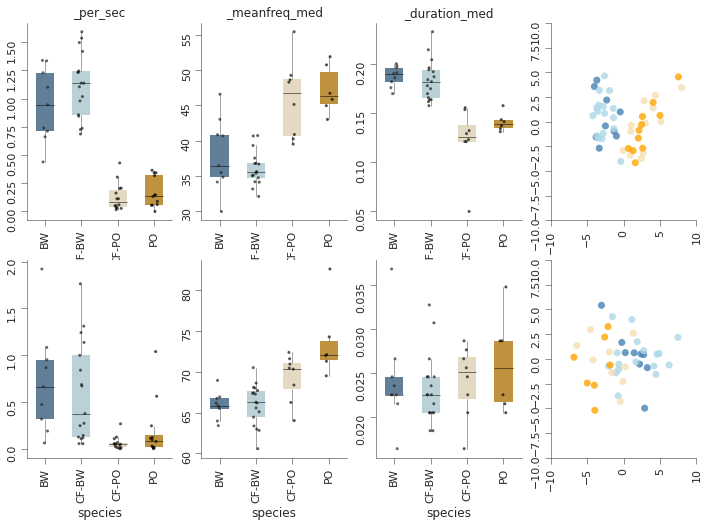

In [158]:
cf_color_dict = {'BW':'steelblue', 
                 'CF-BW':'lightblue',
                 'PO': 'orange',
                 'CF-PO': 'wheat'
                }

#choose to save or not
save = False

#--------------------------------------------------------------------------------------------------------------------#

#drop pups with fewer than min_n vocalizations of either type to calculate features
acoustic_features_data = all_pups.loc[(all_pups['cry_count'] > min_voc_number) & (all_pups['USV_count'] > min_voc_number)]

features = ['_per_sec', 
            '_meanfreq_med', 
             '_duration_med']

voc_types = ['cry', 'USV']


sns.set(style="ticks", color_codes=True)
fig, ax = plt.subplots(nrows=2,
                       ncols=4,
                       figsize=[12,8], 
                       sharex = False)

# get the colors
colors = pd.Series(acoustic_features_data['species'].unique()).map(cf_color_dict)

#plot the box plots
#for each row
for i, voc_type in zip(range(ax.shape[0]), voc_types):
    
    #plot each column
    for j, feature in zip(range(ax.shape[1]), features):

        if 'per_sec' in feature:
            data = all_pups
        else:
            data = acoustic_features_data

        ax[0,j].set_title(feature)
        
        swarm_plot = sns.stripplot(x='species', 
                                   y=voc_type+feature, 
                                   data=data, 
                                   alpha = .7, 
                                   size=3, 
                                   jitter = True,  
                                   color = 'black', 
                                   dodge = False, 
                                   hue = 'species', 
                                   ax = ax[i,j])
        
        swarm_plot = sns.boxplot(x='species', 
                                 y=voc_type+feature,
                                 showcaps=False,
                                 saturation=0.5,
                                 data=data, 
                                 whis=1.5, 
                                 flierprops={"marker": ""},
                                 medianprops={"color": "black"},
                                 width = .5, 
                                 linewidth = .5, 
                                 boxprops={"linewidth": .00001},
                                 dodge = False, 
                                 palette = colors,
                                 hue = 'species',  
                                 ax = ax[i,j])
        
        #prettify
        swarm_plot.legend([],[], frameon=False)
        ax[i,j].set_ylabel('')
        for axis in ['top','bottom','left','right']:
            ax[i,j].spines[axis].set_linewidth(.5)
    
        ax[i,j].xaxis.set_tick_params(width=.5, rotation = 90)
        ax[i,j].yaxis.set_tick_params(width=.5, rotation = 90)
        sns.despine()
        
        
#plot the PCAs

#cry PCA
cry_pca_colors = cry_df_filtered['species'].map(cf_color_dict)
USV_pca_colors = USV_df_filtered['species'].map(cf_color_dict)

#cry PCA
ax[0,3].scatter(cry_df_filtered['pc1'], 
                cry_df_filtered['pc2'],
                c= cry_pca_colors,
                linewidth = 0,
                alpha = .8, 
                s=50)

#USV PCA
ax[1,3].scatter(USV_df_filtered['pc1'], 
                USV_df_filtered['pc2'],
                c= USV_pca_colors,
                linewidth = 0,
                alpha = .8, 
                s=50)

#prettify
swarm_plot.legend([],[], frameon=False)
ax[0,3].set_ylabel('')
ax[1,3].set_ylabel('')

ax[0,3].set_ylabel('')
ax[0,3].set_ylim([-10,10])
ax[0,3].set_xlim([-10,10])

ax[1,3].set_ylabel('')
ax[1,3].set_ylim([-10,10])
ax[1,3].set_xlim([-10,10])

for axis in ['top','bottom','left','right']:
    ax[0,3].spines[axis].set_linewidth(.5)
    ax[1,3].spines[axis].set_linewidth(.5)
    
ax[0,3].xaxis.set_tick_params(width=.5, rotation = 90)
ax[0,3].yaxis.set_tick_params(width=.5, rotation = 90)
ax[1,3].xaxis.set_tick_params(width=.5, rotation = 90)
ax[1,3].yaxis.set_tick_params(width=.5, rotation = 90)
sns.despine()

# if save:
#     save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_5/'
#     save_name = 'cross_foster_4_bad_bw_dropped_min_n_5.pdf'
#     plt.savefig(os.path.join(save_dir, save_name))
    
#     save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_5/'
#     save_name = 'cross_foster_4_bad_bw_dropped_min_n_5.jpeg'
#     plt.savefig(os.path.join(save_dir, save_name), dpi=600)

# Figure 5 (F1 and F2 experiments)

## collect raw data

### collect the F1 raw data

In [164]:
#combine features across conditions into a single dataframe
f1_features_dir = os.path.join(acoustic_features_root, 'bw_po_f1','20220926_073134')

#these are the files to combine
feature_files = ['BW-PO-cross-F1warbler_features.csv', 'cross-BWwarbler_features.csv', 'cross-POwarbler_features.csv']

#combine them
all_combined = []
for file in [i for i in glob.glob(os.path.join(f1_features_dir,'*.csv')) if i.split('/')[-1] in feature_files]:
    temp = pd.read_csv(file)
    all_combined.append(temp)
    
#add useful information
bw_po_f1_features = pd.concat(all_combined)
bw_po_f1_features['species'] = [i.split('_')[0] for i in bw_po_f1_features['source_file']]
bw_po_f1_features['dataset'] = dataset
bw_po_f1_features['segmentation_iteration'] = directory.split('/')[-1]
bw_po_f1_features['pup'] = [i.split('_clip')[0] for i in bw_po_f1_features['source_file']]
bw_po_f1_features = bw_po_f1_features.reset_index(drop=True)
print('duplicates:', bw_po_f1_features.duplicated().sum())

#check for NaNs and drop those vocalizations
print('there are', len(bw_po_f1_features[bw_po_f1_features.isna().any(axis=1)]), 'rows with nan values.')
print('dropping these rows...')
bw_po_f1_features = bw_po_f1_features.dropna(axis=0,how='any')

print('done.')

duplicates: 0
there are 2 rows with nan values.
dropping these rows...
done.


### prediction vocalization types from F1 data

In [166]:
#choose the dataset to process --- this is the only line you need to change to label a new dataset
dataset = 'bw_po_f1'

#get the model
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
model_params = parameters.load(save_dir=os.path.split(voc_type_params_path)[0], save_name=os.path.split(voc_type_params_path)[1])

print('predicting', dataset, 'vocalizations')
df = bw_po_f1_features

#make sure NaNs are dropped (can't predict labels from them)
assert len(df[df.isna().any(axis=1)]) == 0

#check for duplicates (there should be none)
assert df.duplicated().sum() == 0

#get the features needed to predict vocalization type
for_prediction = df[model_params['feature_set']]

#predict vocalization types - takes about 10 minutes 
print('predicting vocalization labels...')
predicted_labels = voc_type_model.predict(for_prediction)
assert set(predicted_labels) == set(['cry', 'scratch', 'whistle'])
assert len(predicted_labels) == len(df)

#give some info
print("total predicted 'cry':", len([i for i in predicted_labels if i=='cry']))
print("total predicted 'whistle':", len([i for i in predicted_labels if i=='whistle']))
print("total predicted 'scratch':", len([i for i in predicted_labels if i=='scratch']))

#add to the dataframe
bw_po_f1_features['predicted_label'] = predicted_labels

#drop the non-vocal sound
bw_po_f1_features = bw_po_f1_features.loc[bw_po_f1_features['predicted_label'] != 'scratch']

print('done.')             

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230116_084254/random_forest_20230116_084254_params
predicting bw_po_f1 vocalizations
predicting vocalization labels...


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


total predicted 'cry': 55581
total predicted 'whistle': 11620
total predicted 'scratch': 301
done.


In [167]:
#TO DO fix the labels and retrain the model
bw_po_f1_features['predicted_label'] = ['USV' if i=='whistle' else i for i in bw_po_f1_features['predicted_label']]

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### aggregate the F1 raw data

In [173]:
#get the pups that you want to aggregate features from
df_to_aggregate = bw_po_f1_features

print('getting pups...')
source_list = [i+'.wav' for i in sorted(bw_po_f1_features['pup'].unique())]

#choose the features to aggregate
metadata_columns = ['source_file', 'species', 'pup', 'predicted_label', 'dataset', 'segmentation_type', 'segmentation_iteration']
features_to_aggregate = model_params['feature_set']

#aggregate the data - this takes a few minutes
print('getting aggregate features for each pup...')
all_pup_features, all_pup_metadata = features.aggregate_all_pups(source_list = source_list, 
                                                                 dataset = 'bw_po_f1', 
                                                                 features = features_to_aggregate, 
                                                                 features_df = df_to_aggregate) 

getting pups...
getting aggregate features for each pup...
done collecting metadata...
BW-PO-cross-F1_24963x24813-family-A_ltr1_pup1_ch2_3300_m_335_303_fr0_p7_2019-11-04_13-20-19.wav
BW-PO-cross-F1_24963x24813-family-A_ltr1_pup1_ch5_4000_m_347_328_fr0_p9_2019-11-06_13-40-21.wav
BW-PO-cross-F1_24963x24813-family-A_ltr1_pup2_ch2_3500_m_359_331_fr0_p9_2019-11-06_13-40-21.wav
BW-PO-cross-F1_24963x24813-family-A_ltr1_pup2_ch4_2900_m_357_308_fr0_p7_2019-11-04_13-20-19.wav
BW-PO-cross-F1_24963x24813-family-A_ltr1_pup3_ch4_4800_f_331_326_fr0_p9_2019-11-06_13-40-21.wav
BW-PO-cross-F1_24963x24813-family-A_ltr1_pup3_ch5_3900_f_343_318_fr0_p7_2019-11-04_13-20-19.wav
BW-PO-cross-F1_24963x24813-family-A_ltr1_pup4_ch6_3600_m_348_302_fr0_p7_2019-11-04_13-20-19.wav
BW-PO-cross-F1_24963x24813-family-A_ltr1_pup4_ch6_4300_m_332_323_fr1_p9_2019-11-06_13-40-21.wav
BW-PO-cross-F1_24963x24813-family-A_ltr2_pup1_ch2_2700_m_341_292_fr0_p7_2019-11-29_13-12-04.wav
BW-PO-cross-F1_24963x24813-family-A_ltr2_pup1_ch2

cross-BW_23355x23420_ltr3_pup4_ch6_5300_m_331_317_fr0_p9_2019-09-13_05-16-40.wav
cross-BW_23355x23420_ltr3_pup5_ch1_4900_m_326_319_fr0_p9_2019-09-13_05-16-40.wav
cross-BW_23355x23420_ltr3_pup5_ch6_4200_m_347_298_fr0_p7_2019-09-11_06-19-14.wav
cross-BW_23355x23420_ltr3_pup6_ch4_5000_m_332_321_fr0_p9_2019-09-13_05-16-40.wav
cross-BW_23355x23420_ltr3_pup6_ch7_4100_m_341_295_fr0_p7_2019-09-11_06-19-14.wav
cross-BW_23531x23296_ltr3_pup1_ch1_3500_f_350_277_fr0_p7_2019-09-13_07-44-49.wav
cross-BW_23531x23296_ltr3_pup1_ch4_4300_f_339_293_fr1_p9_2019-09-15_08-15-38.wav
cross-BW_23531x23296_ltr3_pup2_ch1_4600_f_343_292_fr0_p9_2019-09-15_08-15-38.wav
cross-BW_23531x23296_ltr3_pup2_ch2_3700_f_357_280_fr0_p7_2019-09-13_07-44-49.wav
cross-BW_23531x23296_ltr3_pup3_ch4_3600_m_351_289_fr0_p7_2019-09-13_07-44-49.wav
cross-BW_23531x23296_ltr3_pup3_ch7_4300_m_331_293_fr0_p9_2019-09-15_08-15-38.wav
cross-BW_23531x23296_ltr3_pup4_ch2_4400_m_346_292_fr1_p9_2019-09-15_08-15-38.wav
cross-BW_23531x23296_ltr3_pu

cross-PO_20417x18962_ltr4_pup3_ch3_3100_f_361_290_fr0_p7_2019-08-17_14-06-47.wav
cross-PO_20417x18962_ltr4_pup4_ch4_3500_f_356_303_fr0_p7_2019-08-17_14-06-47.wav
cross-PO_20417x18962_ltr4_pup4_ch4_4200_f_350_310_fr0_p9_2019-08-19_14-04-24.wav
cross-PO_20481x19875_ltr6_pup1_ch1_2800_f_361_294_fr0_p7_2019-08-24_13-44-05.wav
cross-PO_20481x19875_ltr6_pup1_ch2_3500_f_348_311_fr0_p9_2019-08-26_13-47-49.wav
cross-PO_20481x19875_ltr6_pup2_ch2_2700_f_360_281_fr0_p7_2019-08-24_13-44-05.wav
cross-PO_20481x19875_ltr6_pup2_ch3_3400_f_344_298_fr0_p9_2019-08-26_13-47-49.wav
cross-PO_20481x19875_ltr6_pup3_ch3_2700_m_364_291_fr0_p7_2019-08-24_13-44-05.wav
cross-PO_20481x19875_ltr6_pup3_ch5_3300_m_336_287_fr1_p9_2019-08-26_13-47-49.wav
cross-PO_20481x19875_ltr6_pup4_ch4_2900_f_354_279_fr0_p7_2019-08-24_13-44-05.wav
cross-PO_20481x19875_ltr6_pup4_ch4_3500_f_336_300_fr0_p9_2019-08-26_13-47-49.wav
cross-PO_20481x19875_ltr6_pup5_ch1_3400_m_348_303_fr0_p9_2019-08-26_13-47-49.wav
cross-PO_20481x19875_ltr6_pu

In [174]:
# merge metadata and acoustic features
assert(all_pup_features['pup'].equals(all_pup_metadata['pup']))
vocal_pups = all_pup_features.merge(all_pup_metadata, on='pup')

#add the pups that made no detected sounds 
#find them
non_vocal_pups = [i for i in sorted(os.listdir(all_wav_bw_po_f1)) if i not in sorted(vocal_pups['pup']) and not i.startswith('.')]

if len(non_vocal_pups) != 0:
    print('adding nonvocal pups...')
    
    #get their metadata
    non_vocal_meta_data_list = []
    for pup in non_vocal_pups:
        pup_metadata = features.get_pup_metadata(source_path = pup, dataset = dataset)
        non_vocal_meta_data_list.append(pup_metadata)
    non_vocal_meta_data_df = pd.DataFrame(non_vocal_meta_data_list)

    #make columns for their features (which will be all nan)
    non_vocal_features_df = pd.DataFrame(columns =all_pup_features.columns)
    non_vocal_features_df['pup'] = non_vocal_meta_data_df['pup']
    non_vocal_data_df = non_vocal_features_df.merge(non_vocal_meta_data_df, on='pup')

    #add to the vocalizing pups
    assert sorted(vocal_pups.columns) == sorted(non_vocal_data_df.columns)
    all_pups = pd.concat([vocal_pups, non_vocal_data_df])
    all_pups = all_pups.sort_values(by='pup').reset_index(drop=True)

    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(raw_wavs_root) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = {}
    for pup in all_pups['pup']:
        path = os.path.join(all_wav_bw_po_f1, pup)
        fs, wav = wavfile.read(path)
        rec_length_dict[pup] = len(wav)/fs
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['removal_flag'] = [int(i[2:]) if 'fr' in i else float('NaN') for i in all_pups['removal_flag']]
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']

    print('done.')
    
else:
    print('no non-vocal pups to add...')
    all_pups = vocal_pups.copy()
    
    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(all_wav_bw_po_f1) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = {}
    for pup in all_pups['pup']:
        path = os.path.join(all_wav_bw_po_f1, pup)
        fs, wav = wavfile.read(path)
        rec_length_dict[pup] = len(wav)/fs
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']
    f1_df = all_pups.drop(columns = [i for i in all_pups.columns if 'scratch' in i]) #ignore columns about non-vocal sound

    print('done.')
    

no non-vocal pups to add...
getting recording lengths...


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:68: WavFileWarning: Chunk (non-data) not understood, skipping it.


finalizing dataset...
done.


### collect the F2 raw data

In [176]:
f2_features_dir = os.path.join(acoustic_features_root, 'bw_po_f2','20220926_101549')

#these are the files to combine
feature_files = ['ch1warbler_features.csv', 
                 'ch2warbler_features.csv', 
                 'ch3warbler_features.csv', 
                 'ch4warbler_features.csv', 
                 'ch5warbler_features.csv', 
                 'ch6warbler_features.csv', 
                 'ch7warbler_features.csv', 
                 'ch8warbler_features.cs']

#combine them
all_combined = []
for file in [i for i in glob.glob(os.path.join(f2_features_dir,'*.csv')) if i.split('/')[-1] in feature_files]:
    temp = pd.read_csv(file)
    all_combined.append(temp)
    
#add useful information
bw_po_f2_features = pd.concat(all_combined)
bw_po_f2_features['species'] = [i.split('_')[0] for i in bw_po_f2_features['source_file']]
bw_po_f2_features['dataset'] = dataset
bw_po_f2_features['segmentation_iteration'] = directory.split('/')[-1]
bw_po_f2_features['pup'] = [i.split('_clip')[0] for i in bw_po_f2_features['source_file']]
bw_po_f2_features = bw_po_f2_features.reset_index(drop=True)
print('duplicates:', bw_po_f2_features.duplicated().sum())

#check for NaNs and drop those vocalizations
print('there are', len(bw_po_f2_features[bw_po_f2_features.isna().any(axis=1)]), 'rows with nan values.')
print('dropping these rows...')
bw_po_f2_features = bw_po_f2_features.dropna(axis=0,how='any')

print('done.')

duplicates: 0
there are 4 rows with nan values.
dropping these rows...
done.


### predict vocalization types from F2 data

In [177]:
#choose the dataset to process --- this is the only line you need to change to label a new dataset
dataset = 'bw_po_f2'

#get the model
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
model_params = parameters.load(save_dir=os.path.split(voc_type_params_path)[0], save_name=os.path.split(voc_type_params_path)[1])

print('predicting', dataset, 'vocalizations')
df = bw_po_f2_features

#make sure NaNs are dropped (can't predict labels from them)
assert len(df[df.isna().any(axis=1)]) == 0

#check for duplicates (there should be none)
assert df.duplicated().sum() == 0

#get the features needed to predict vocalization type
for_prediction = df[model_params['feature_set']]

#predict vocalization types - takes about 10 minutes 
print('predicting vocalization labels...')
predicted_labels = voc_type_model.predict(for_prediction)
assert set(predicted_labels) == set(['cry', 'scratch', 'whistle'])
assert len(predicted_labels) == len(df)

#give some info
print("total predicted 'cry':", len([i for i in predicted_labels if i=='cry']))
print("total predicted 'whistle':", len([i for i in predicted_labels if i=='whistle']))
print("total predicted 'scratch':", len([i for i in predicted_labels if i=='scratch']))

#add to the dataframe
bw_po_f2_features['predicted_label'] = predicted_labels

#drop the non-vocal sound
bw_po_f2_features = bw_po_f2_features.loc[bw_po_f2_features['predicted_label'] != 'scratch']

print('done.')             

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230116_084254/random_forest_20230116_084254_params
predicting bw_po_f2 vocalizations
predicting vocalization labels...


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


total predicted 'cry': 302611
total predicted 'whistle': 44002
total predicted 'scratch': 1050
done.


In [178]:
#TO DO fix the labels and retrain the model
bw_po_f2_features['predicted_label'] = ['USV' if i=='whistle' else i for i in bw_po_f2_features['predicted_label']]

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### aggregate F2 raw data

In [218]:
#get the pups that you want to aggregate features from
df_to_aggregate = bw_po_f2_features

print('getting pups...')
source_list = [i+'.wav' for i in sorted(bw_po_f2_features['pup'].unique())]

#choose the features to aggregate
metadata_columns = ['source_file', 'species', 'pup', 'predicted_label', 'dataset', 'segmentation_type', 'segmentation_iteration']
features_to_aggregate = model_params['feature_set']

#aggregate the data - this takes a few minutes
print('getting aggregate features for each pup...')
all_pup_features, all_pup_metadata = features.aggregate_all_pups(source_list = source_list, 
                                                                 dataset = 'bw_po_f2', 
                                                                 features = features_to_aggregate, 
                                                                 features_df = df_to_aggregate) 

getting pups...
getting aggregate features for each pup...
done collecting metadata...
ch1_BWxPO-cross-F2_26159x26161_fam-A3_ltr3_pup1_ch1_4000_m_341_270_fr0_p7_2020-12-08_14-10-47.wav
ch1_BWxPO-cross-F2_27005x27489_fam-D2_ltr2_pup3_ch1_4400_f_325_311_fr0_p9_2020-11-18_14-31-06.wav
ch1_BWxPO-cross-F2_27489x27005_fam-D2_ltr2_pup1_ch1_3100_f_348_282_fr0_p7_2020-11-16_14-51-53.wav
ch1_BWxPO-cross-F2_27490x26878_fam-D3_ltr1_pup7_ch1_4100_m_340_287_fr0_p7_2020-10-21_13-24-05.wav
ch1_BWxPO-cross-F2_27490x26878_fam-D3_ltr1_pup7_ch1_5000_m_327_301_fr0_p9_2020-10-23_12-43-23.wav
ch1_BWxPO-cross-F2_28206x28208_fam-D4_ltr2_pup1_ch1_3800_m_351_273_fr0_p7_2020-12-08_13-32-48.wav
ch1_BWxPO-cross-F2_28207x28209_fam-D5_ltr1_pup1_ch1_3700_f_360_303_fr0_p7_2020-12-09_13-02-37.wav
ch2_BWxPO-cross-F2_25704x25707_fam-A1_ltr1_pup1_ch2_3900_m_366_295_fr0_p7_2020-01-17_14-00-16.wav
ch2_BWxPO-cross-F2_25704x25707_fam-A1_ltr1_pup1_ch2_4400_m_348_299_fr0_p9_2020-01-19_13-22-00.wav
ch2_BWxPO-cross-F2_25704x25707_

ch2_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup1_ch2_3400_f_343_291_fr0_p7_2021-04-14_17-27-18.wav
ch2_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup1_ch2_4000_f_345_311_fr0_p9_2021-04-16_15-26-07.wav
ch2_BWxPO-cross-F2_26878x27490_fam-D3_ltr7_pup1_ch2_4000_m_361_291_fr0_p7_2021-05-09_13-38-38.wav
ch2_BWxPO-cross-F2_26878x27490_fam-D3_ltr7_pup6_ch2_2800_f_353_313_fr0_p9_2021-05-11_13-03-26.wav
ch2_BWxPO-cross-F2_26878x27490_fam-D3_ltr8_pup1_ch2_4000_m_338_307_fr0_p7_2021-06-27_13-07-33.wav
ch2_BWxPO-cross-F2_26878x27490_fam-D3_ltr8_pup3_ch2_3800_f_335_306_fr0_p9_2021-06-29_13-17-31.wav
ch2_BWxPO-cross-F2_26878x27940_fam-D3_ltr3_pup1_ch2_4100_f_359_321_fr0_p7_2021-01-30_15-22-50.wav
ch2_BWxPO-cross-F2_26879x27489_fam-D2_ltr3_pup1_ch2_3800_m_363_315_fr0_p7_2021-01-24_17-34-10.wav
ch2_BWxPO-cross-F2_26879x27489_fam-D2_ltr3_pup4_ch2_4400_f_349_326_fr0_p9_2021-01-26_15-13-55.wav
ch2_BWxPO-cross-F2_26879x27489_fam-D2_ltr4_pup1_ch2_3300_f_353_303_fr0_p7_2021-02-17_14-20-06.wav
ch2_BWxPO-cross-F2_2

ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr1_pup2_ch2_4100_m_342_305_fr0_p9_2021-01-17_15-28-44.wav
ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr2_pup1_ch2_2700_f_363_309_fr0_p7_2021-02-11_14-33-14.wav
ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr2_pup2_ch2_4800_m_350_302_fr0_p9_2021-02-13_16-55-49.wav
ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr3_pup1_ch2_3000_f_354_297_fr0_p7_2021-03-07_16-26-47.wav
ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr3_pup3_ch2_4000_f_339_306_fr0_p9_2021-03-09_13-32-45.wav
ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr4_pup1_ch2_3000_f_348_304_fr0_p7_2021-04-03_15-27-33.wav
ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr4_pup2_ch2_2900_m_354_296_fr0_p9_2021-04-05_19-17-05.wav
ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr5_pup1_ch2_4500_m_356_296_fr0_p7_2021-04-26_17-21-22.wav
ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr5_pup2_ch2_4200_m_345_310_fr0_p9_2021-04-28_12-55-16.wav
ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr6_pup1_ch2_4000_m_355_302_fr0_p7_2021-05-22_13-49-11.wav
ch2_BWxPO-cross-F2_2

ch2_BWxPO-cross-F2_28456x28459_fam-D7_ltr7_pup1_ch2_3900_m_353_278_fr0_p7_2021-06-23_14-10-40.wav
ch2_BWxPO-cross-F2_28456x28459_fam-D7_ltr7_pup1_ch2_4700_m_339_291_fr0_p9_2021-06-25_15-36-14.wav
ch2_BWxPO-cross-F2_28457x28458_fam-D6_ltr1_pup1_ch2_2600_m_351_296_fr0_p7_2021-01-20_16-48-06.wav
ch2_BWxPO-cross-F2_28457x28458_fam-D6_ltr1_pup1_ch2_3300_m_341_309_fr0_p9_2021-01-22_17-08-24.wav
ch2_BWxPO-cross-F2_28457x28458_fam-D6_ltr2_pup1_ch2_2100_m_365_294_fr0_p7_2021-02-11_14-01-26.wav
ch2_BWxPO-cross-F2_28457x28458_fam-D6_ltr2_pup1_ch2_2800_m_355_290_fr0_p9_2021-02-13_15-26-56.wav
ch2_BWxPO-cross-F2_28457x28458_fam-D6_ltr3_pup1_ch2_3600_m_354_304_fr0_p7_2021-03-08_16-58-29.wav
ch2_BWxPO-cross-F2_28457x28458_fam-D6_ltr3_pup1_ch2_4100_m_351_312_fr0_p9_2021-03-10_13-19-58.wav
ch2_BWxPO-cross-F2_28457x28458_fam-D6_ltr4_pup1_ch2_4700_m_353_305_fr0_p7_2021-04-03_14-58-46.wav
ch2_BWxPO-cross-F2_28457x28458_fam-D6_ltr4_pup1_ch2_5800_m_351_315_fr0_p9_2021-04-05_18-08-24.wav
ch2_BWxPO-cross-F2_2

ch3_BWxPO-cross-F2_25704x25707_fam-A1_ltr6_pup2_ch3_3400_m_346_296_fr0_p7_2021-04-04_14-10-15.wav
ch3_BWxPO-cross-F2_25704x25707_fam-A1_ltr7_pup2_ch3_3800_f_348_289_fr0_p7_2021-05-02_13-57-53.wav
ch3_BWxPO-cross-F2_25704x25707_fam-A1_ltr7_pup2_ch3_4500_f_347_312_fr0_p9_2021-05-04_12-53-36.wav
ch3_BWxPO-cross-F2_25704x25707_fam-A1_ltr8_pup2_ch3_3700_m_343_283_fr1_p7_2021-05-28_15-52-38.wav
ch3_BWxPO-cross-F2_25704x25707_fam-A1_ltr8_pup2_ch3_4400_m_334_289_fr1_p9_2021-05-30_12-41-11.wav
ch3_BWxPO-cross-F2_26158x26160_fam-A4_ltr2_pup1_ch3_3900_m_357_308_fr0_p9_2021-01-25_17-36-53.wav
ch3_BWxPO-cross-F2_26158x26160_fam-A4_ltr2_pup2_ch3_2900_f_363_312_fr1_p7_2021-01-23_15-46-49.wav
ch3_BWxPO-cross-F2_26158x26160_fam-A4_ltr3_pup2_ch3_2500_f_356_271_fr0_p7_2021-02-15_16-57-07.wav
ch3_BWxPO-cross-F2_26158x26160_fam-A4_ltr3_pup5_ch3_3100_m_343_318_fr0_p9_2021-02-17_18-26-02.wav
ch3_BWxPO-cross-F2_26158x26160_fam-A4_ltr4_pup1_ch3_3900_f_347_308_fr0_p9_2021-03-15_18-10-19.wav
ch3_BWxPO-cross-F2_2

ch3_BWxPO-cross-F2_27004x27488_fam-D1_ltr7_pup1_ch3_4000_f_323_312_fr0_p9_2021-06-08_12-11-43.wav
ch3_BWxPO-cross-F2_27004x27488_fam-D1_ltr7_pup2_ch3_4900_m_340_271_fr0_p7_2021-06-06_15-49-14.wav
ch3_BWxPO-cross-F2_27004x27488_fam-D1_ltr8_pup2_ch3_3000_f_348_283_fr0_p7_2021-06-30_15-29-54.wav
ch3_BWxPO-cross-F2_27004x27488_fam-D1_ltr8_pup4_ch3_4000_f_340_308_fr0_p9_2021-07-02_13-44-29.wav
ch3_BWxPO-cross-F2_27005x27489_fam-D2_ltr2_pup2_ch3_4300_f_337_321_fr0_p9_2020-11-18_14-31-06.wav
ch3_BWxPO-cross-F2_27212x27213_fam-B4_ltr1_pup2_ch3_3000_f_330_286_fr0_p7_2021-01-14_12-56-13.wav
ch3_BWxPO-cross-F2_27212x27213_fam-B4_ltr1_pup2_ch3_3400_f_318_297_fr1_p9_2021-01-16_15-52-56.wav
ch3_BWxPO-cross-F2_27212x27213_fam-B4_ltr2_pup2_ch3_2600_f_357_283_fr0_p7_2021-02-12_17-10-03.wav
ch3_BWxPO-cross-F2_27212x27213_fam-B4_ltr2_pup2_ch3_3200_f_338_303_fr0_p9_2021-02-14_14-23-15.wav
ch3_BWxPO-cross-F2_27212x27213_fam-B4_ltr3_pup2_ch3_3500_m_353_281_fr0_p7_2021-03-11_16-19-10.wav
ch3_BWxPO-cross-F2_2

ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr4_pup2_ch3_3600_f_358_306_fr0_p7_2021-03-19_14-06-11.wav
ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr4_pup3_ch3_4100_m_353_301_fr0_p9_2021-03-21_13-00-32.wav
ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr5_pup2_ch3_4400_m_342_288_fr0_p7_2021-04-14_18-00-14.wav
ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr5_pup3_ch3_4200_m_343_309_fr0_p9_2021-04-16_17-12-46.wav
ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr6_pup2_ch3_3900_f_352_302_fr1_p7_2021-05-10_16-35-22.wav
ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr6_pup3_ch3_4500_f_335_305_fr0_p9_2021-05-12_13-57-38.wav
ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr7_pup2_ch3_2700_m_349_280_fr0_p7_2021-06-30_16-00-56.wav
ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr7_pup5_ch3_3400_f_327_299_fr0_p9_2021-07-02_15-07-19.wav
ch3_BWxPO-cross-F2_28339x28341_fam-A9_ltr2_pup2_ch3_4200_f_357_321_fr0_p7_2021-01-22_19-04-23.wav
ch3_BWxPO-cross-F2_28339x28341_fam-A9_ltr2_pup3_ch3_4300_f_348_313_fr1_p9_2021-01-24_15-10-20.wav
ch3_BWxPO-cross-F2_2

ch3_BWxPO-cross-F2_29205x29207_fam-A12_ltr3_pup1_ch3_5600_f_331_319_fr0_p9_2021-06-24_18-36-24.wav
ch3_BWxPO-cross-F2_29205x29207_fam-A12_ltr3_pup2_ch3_3000_f_348_281_fr0_p7_2021-06-22_17-27-10.wav
ch3_BWxPO-cross-F2_29205x29207_fam-A12_ltr4_pup2_ch3_4600_m_344_309_fr0_p7_2021-07-15_13-22-17.wav
ch3_BWxPO-cross-F2_29205x29207_fam-A12_ltr4_pup2_ch3_5700_m_327_307_fr0_p9_2021-07-17_13-30-54.wav
ch3_BWxPO-cross-F2_29206x28981_fam-A11_ltr1_pup2_ch3_4600_m_345_288_fr0_p7_2021-05-03_17-21-13.wav
ch3_BWxPO-cross-F2_29206x28981_fam-A11_ltr1_pup3_ch3_5400_m_338_315_fr0_p9_2021-05-05_12-45-02.wav
ch3_BWxPO-cross-F2_29206x28981_fam-A11_ltr2_pup2_ch3_3700_f_360_312_fr0_p7_2021-05-28_16-19-58.wav
ch3_BWxPO-cross-F2_29206x28981_fam-A11_ltr2_pup2_ch3_4200_f_338_318_fr0_p9_2021-05-30_13-38-57.wav
ch3_BWxPO-cross-F2_29206x28981_fam-A11_ltr3_pup1_ch3_4900_m_341_296_fr0_p9_2021-06-24_13-54-07.wav
ch3_BWxPO-cross-F2_29206x28981_fam-A11_ltr3_pup2_ch3_4500_m_335_278_fr0_p7_2021-06-22_15-35-04.wav
ch3_BWxPO-

ch4_BWxPO-cross-F2_26366x26370_fam-A5_ltr6_pup3_ch4_3300_f_345_270_fr1_p7_2021-05-23_12-24-46.wav
ch4_BWxPO-cross-F2_26366x26370_fam-A5_ltr7_pup2_ch4_4500_m_344_310_fr1_p9_2021-06-19_12-42-09.wav
ch4_BWxPO-cross-F2_26366x26370_fam-A5_ltr7_pup3_ch4_3400_f_346_278_fr0_p7_2021-06-17_13-37-01.wav
ch4_BWxPO-cross-F2_26366x26370_fam-A5_ltr8_pup2_ch4_4300_m_328_278_fr0_p9_2021-07-13_13-26-14.wav
ch4_BWxPO-cross-F2_26366x26370_fam-A5_ltr8_pup3_ch4_2200_m_330_283_fr0_p7_2021-07-11_14-09-15.wav
ch4_BWxPO-cross-F2_26874x27489_fam-D2_ltr8_pup1_ch4_5100_f_328_309_fr0_p9_2021-06-24_19-44-12.wav
ch4_BWxPO-cross-F2_26878x27490_fam-D3_ltr2_pup3_ch4_2500_f_333_288_fr0_p7_2021-01-05_14-27-50.wav
ch4_BWxPO-cross-F2_26878x27490_fam-D3_ltr2_pup7_ch4_4900_m_338_323_fr0_p9_2021-01-07_17-05-59.wav
ch4_BWxPO-cross-F2_26878x27490_fam-D3_ltr3_pup4_ch4_4100_f_339_319_fr0_p9_2021-02-01_17-47-10.wav
ch4_BWxPO-cross-F2_26878x27490_fam-D3_ltr4_pup2_ch4_5000_m_350_331_fr0_p9_2021-02-26_16-29-55.wav
ch4_BWxPO-cross-F2_2

ch4_BWxPO-cross-F2_27732x27733_fam-B5_ltr7_pup3_ch4_3000_m_344_280_fr0_p7_2021-06-15_13-20-38.wav
ch4_BWxPO-cross-F2_27732x27733_fam-B5_ltr7_pup3_ch4_3600_m_337_315_fr0_p9_2021-06-17_14-03-49.wav
ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr2_pup2_ch4_5300_f_320_296_fr0_p9_2021-01-28_14-51-13.wav
ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr2_pup3_ch4_4600_f_324_310_fr0_p7_2021-01-26_17-43-59.wav
ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr3_pup1_ch4_3500_m_348_290_fr1_p9_2021-02-19_13-08-31.wav
ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr3_pup3_ch4_4800_m_351_293_fr0_p7_2021-02-17_13-17-35.wav
ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr4_pup1_ch4_3700_f_343_293_fr0_p9_2021-03-17_17-12-05.wav
ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr4_pup3_ch4_5200_m_348_293_fr0_p7_2021-03-15_17-31-53.wav
ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr5_pup3_ch4_2700_m_345_272_fr0_p7_2021-04-10_17-53-20.wav
ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr6_pup3_ch4_4700_m_343_287_fr0_p7_2021-05-27_15-16-37.wav
ch4_BWxPO-cross-F2_2

ch4_BWxPO-cross-F2_28693x28694_fam-D8_ltr7_pup2_ch4_4200_f_333_292_fr0_p9_2021-07-07_13-22-41.wav
ch4_BWxPO-cross-F2_28693x28694_fam-D8_ltr7_pup3_ch4_3800_f_347_278_fr0_p7_2021-07-05_14-53-11.wav
ch4_BWxPO-cross-F2_28963x28694_fam-D8_ltr1_pup3_ch4_3000_f_343_305_fr0_p7_2021-01-18_15-29-33.wav
ch4_BWxPO-cross-F2_28978x28979_fam-A10_ltr2_pup3_ch4_3000_f_355_290_fr0_p7_2021-02-17_13-47-20.wav
ch4_BWxPO-cross-F2_28978x28979_fam-A10_ltr2_pup5_ch4_4200_f_345_325_fr0_p9_2021-02-19_15-58-47.wav
ch4_BWxPO-cross-F2_29204x28980_fam-A13_ltr1_pup1_ch4_4100_m_343_308_fr0_p9_2021-05-05_13-43-49.wav
ch4_BWxPO-cross-F2_29204x28980_fam-A13_ltr1_pup3_ch4_4300_f_338_288_fr1_p7_2021-05-03_17-48-42.wav
ch4_BWxPO-cross-F2_29205x29207_fam-A12_ltr2_pup3_ch4_3500_f_341_290_fr0_p7_2021-05-28_16-47-25.wav
ch4_BWxPO-cross-F2_29205x29207_fam-A12_ltr2_pup4_ch4_5000_f_336_309_fr0_p9_2021-05-30_14-29-55.wav
ch4_BWxPO-cross-F2_29205x29207_fam-A12_ltr3_pup3_ch4_5400_f_338_295_fr1_p7_2021-06-22_17-27-10.wav
ch4_BWxPO-cro

ch5_BWxPO-cross-F2_26878x27490_fam-D3_ltr5_pup4_ch5_3300_f_347_300_fr0_p7_2021-03-20_13-11-27.wav
ch5_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup2_ch5_3100_f_351_296_fr0_p9_2021-04-16_15-26-07.wav
ch5_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup4_ch5_3800_f_342_295_fr0_p7_2021-04-14_17-27-18.wav
ch5_BWxPO-cross-F2_26878x27490_fam-D3_ltr7_pup3_ch5_4300_f_342_313_fr0_p9_2021-05-11_13-03-26.wav
ch5_BWxPO-cross-F2_26878x27490_fam-D3_ltr7_pup4_ch5_3700_f_351_295_fr0_p7_2021-05-09_13-38-38.wav
ch5_BWxPO-cross-F2_26878x27490_fam-D3_ltr8_pup2_ch5_5000_m_330_300_fr0_p9_2021-06-29_13-17-31.wav
ch5_BWxPO-cross-F2_26878x27490_fam-D3_ltr8_pup4_ch5_4700_m_346_279_fr0_p7_2021-06-27_13-07-33.wav
ch5_BWxPO-cross-F2_26878x27940_fam-D3_ltr3_pup4_ch5_3400_f_346_317_fr0_p7_2021-01-30_15-22-50.wav
ch5_BWxPO-cross-F2_26879x27489_fam-D2_ltr3_pup4_ch5_3700_f_358_305_fr0_p7_2021-01-24_17-34-10.wav
ch5_BWxPO-cross-F2_26879x27489_fam-D2_ltr3_pup6_ch5_4700_m_346_332_fr0_p9_2021-01-26_15-13-55.wav
ch5_BWxPO-cross-F2_2

ch5_BWxPO-cross-F2_28339x28341_fam-A9_ltr9_pup4_ch5_4400_m_351_277_fr0_p7_2021-07-10_16-21-40.wav
ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr2_pup4_ch5_3700_f_356_297_fr1_p7_2021-02-10_18-18-34.wav
ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr2_pup5_ch5_4400_f_324_300_fr0_p9_2021-02-12_15-33-06.wav
ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr4_pup1_ch5_3400_f_338_294_fr0_p9_2021-04-06_17-23-14.wav
ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr4_pup4_ch5_3800_m_356_289_fr0_p7_2021-04-04_15-11-36.wav
ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr5_pup4_ch5_3600_f_334_296_fr0_p7_2021-05-01_13-53-48.wav
ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr5_pup4_ch5_4300_f_342_305_fr0_p9_2021-05-03_16-00-53.wav
ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr6_pup1_ch5_4100_m_335_290_fr1_p9_2021-05-30_15-39-10.wav
ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr6_pup4_ch5_3800_f_341_306_fr0_p7_2021-05-28_17-18-08.wav
ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr7_pup4_ch5_3700_m_345_274_fr0_p7_2021-06-23_14-10-40.wav
ch5_BWxPO-cross-F2_2

ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr4_pup5_ch6_3100_m_353_299_fr0_p7_2021-02-17_14-20-06.wav
ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr5_pup2_ch6_4700_m_344_318_fr0_p9_2021-03-16_19-10-55.wav
ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr5_pup5_ch6_4100_m_342_301_fr0_p7_2021-03-14_16-49-26.wav
ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr6_pup5_ch6_2100_f_345_299_fr0_p7_2021-04-08_16-12-46.wav
ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr6_pup5_ch6_3000_f_335_310_fr0_p9_2021-04-10_15-23-05.wav
ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr7_pup4_ch6_4000_m_331_294_fr0_p9_2021-05-29_14-34-37.wav
ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr7_pup5_ch6_3800_f_351_301_fr0_p7_2021-05-27_15-45-23.wav
ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr9_pup5_ch6_3600_m_326_292_fr0_p7_2021-07-15_13-51-56.wav
ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr9_pup5_ch6_4100_m_321_300_fr0_p9_2021-07-17_14-38-49.wav
ch6_BWxPO-cross-F2_27004x27488_fam-D1_ltr2_pup1_ch6_5200_m_336_310_fr0_p9_2021-01-07_19-22-11.wav
ch6_BWxPO-cross-F2_2

ch7_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup5_ch7_4200_f_346_304_fr0_p9_2021-04-16_15-26-07.wav
ch7_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup6_ch7_3500_m_343_282_fr0_p7_2021-04-14_17-27-18.wav
ch7_BWxPO-cross-F2_26878x27490_fam-D3_ltr7_pup2_ch7_5300_m_334_307_fr1_p9_2021-05-11_13-03-26.wav
ch7_BWxPO-cross-F2_26878x27490_fam-D3_ltr7_pup6_ch7_2300_f_348_284_fr0_p7_2021-05-09_13-38-38.wav
ch7_BWxPO-cross-F2_26878x27940_fam-D3_ltr3_pup6_ch7_3200_f_339_312_fr0_p7_2021-01-30_15-22-50.wav
ch7_BWxPO-cross-F2_26879x27489_fam-D2_ltr3_pup3_ch7_3800_f_336_325_fr0_p9_2021-01-26_15-13-55.wav
ch7_BWxPO-cross-F2_26879x27489_fam-D2_ltr3_pup6_ch7_4200_m_358_312_fr0_p7_2021-01-24_17-34-10.wav
ch7_BWxPO-cross-F2_26879x27489_fam-D2_ltr6_pup6_ch7_3600_f_338_299_fr0_p7_2021-04-08_16-12-46.wav
ch7_BWxPO-cross-F2_26879x27489_fam-D2_ltr6_pup6_ch7_4300_f_333_304_fr0_p9_2021-04-10_15-23-05.wav
ch7_BWxPO-cross-F2_26879x27489_fam-D2_ltr7_pup6_ch7_3400_f_341_299_fr0_p7_2021-05-27_15-45-23.wav
ch7_BWxPO-cross-F2_2

In [220]:
# merge metadata and acoustic features
assert(all_pup_features['pup'].equals(all_pup_metadata['pup']))
vocal_pups = all_pup_features.merge(all_pup_metadata, on='pup')

#add the pups that made no detected sounds 
#find them
non_vocal_pups = [i for i in sorted(os.listdir(all_wav_bw_po_f2)) if i not in sorted(vocal_pups['pup']) and not i.startswith('.')]

if len(non_vocal_pups) != 0:
    print('adding nonvocal pups...')
    
    #get their metadata
    non_vocal_meta_data_list = []
    for pup in non_vocal_pups:
        pup_metadata = features.get_pup_metadata(source_path = pup, dataset = dataset)
        non_vocal_meta_data_list.append(pup_metadata)
    non_vocal_meta_data_df = pd.DataFrame(non_vocal_meta_data_list)

    #make columns for their features (which will be all nan)
    non_vocal_features_df = pd.DataFrame(columns =all_pup_features.columns)
    non_vocal_features_df['pup'] = non_vocal_meta_data_df['pup']
    non_vocal_data_df = non_vocal_features_df.merge(non_vocal_meta_data_df, on='pup')

    #add to the vocalizing pups
    assert sorted(vocal_pups.columns) == sorted(non_vocal_data_df.columns)
    all_pups = pd.concat([vocal_pups, non_vocal_data_df])
    all_pups = all_pups.sort_values(by='pup').reset_index(drop=True)

    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(all_wav_bw_po_f2) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = {}
    for pup in all_pups['pup']:
        path = os.path.join(all_wav_bw_po_f2, pup)
        fs, wav = wavfile.read(path)
        rec_length_dict[pup] = len(wav)/fs
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['removal_flag'] = [int(i[2:]) if 'fr' in i else float('NaN') for i in all_pups['removal_flag']]
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']

    print('done.')
    
else:
    print('no non-vocal pups to add...')
    all_pups = vocal_pups.copy()
    
    #make sure you have all the pups now
    assert len(all_pups) == len([i for i in os.listdir(all_wav_bw_po_f2) if not i.startswith('.')])

    #get the recording lengths so you can calculate vocalizations per second - this takes about 10 minutes
    print('getting recording lengths...')
    rec_length_dict = {}
    for pup in all_pups['pup']:
        path = os.path.join(all_wav_bw_po_f2, pup)
        fs, wav = wavfile.read(path)
        rec_length_dict[pup] = len(wav)/fs
    rec_length_df = pd.DataFrame()
    rec_length_df['pup'] = rec_length_dict.keys()
    rec_length_df['recording_length'] = rec_length_dict.values()
    all_pups = all_pups.merge(rec_length_df, on='pup')

    #replace count nan with 0 and add some useful columns
    print('finalizing dataset...')
    all_pups['age'] = [int(i[1:]) for i in all_pups['age'] if 'p' in i]
    all_pups['cry_count'] = all_pups['cry_count'].replace(np.nan, 0)
    all_pups['USV_count'] = all_pups['USV_count'].replace(np.nan, 0)
    all_pups['cry_per_sec'] = all_pups['cry_count']/all_pups['recording_length']
    all_pups['USV_per_sec'] = all_pups['USV_count']/all_pups['recording_length']
    all_pups['vocs_per_sec'] = all_pups['total_vocalizations_detected']/all_pups['recording_length']
    f2_df = all_pups.drop(columns = [i for i in all_pups.columns if 'scratch' in i]) #ignore columns about non-vocal sound

    print('done.')
    

adding nonvocal pups...
getting recording lengths...


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:37: WavFileWarning: Chunk (non-data) not understood, skipping it.


finalizing dataset...
done.


## PCA of F1 data

### get the data

In [ ]:
f1_df = f1_df.loc[f1_df['age'] == 9]

In [ ]:
#get the parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')

min_voc_number = params_dict['figure_5']['min_voc_number'] #pup has to have at least this many vocs of each type to be considered
print('excluding pups with fewer than', min_voc_number, 'vocalizations...')

#features for PCA
cry_features = params_dict['figure_5']['cry_features']
USV_features = params_dict['figure_5']['USV_features']

#pups to exclude
to_drop = params_dict['excluded_pups']['bw_po_f1']
f1_df = f1_df.loc[~f1_df['pup'].isin(to_drop)]

################################################################################

#cry PCA preprocessing
cry_df_filtered = f1_df[cry_features]
cry_df_filtered= cry_df_filtered.dropna()
cry_df_filtered = cry_df_filtered.loc[cry_df_filtered['cry_count'] > min_voc_number]
cry_df_filtered= cry_df_filtered.dropna()
cry_df_pca = cry_df_filtered.drop(columns=['species', 'pup', 'cry_count'])
cry_standardized_features = StandardScaler().fit_transform(cry_df_pca)

#USV PCA preprocessing
USV_df_filtered = f1_df[USV_features]
USV_df_filtered = USV_df_filtered.dropna()
USV_df_filtered = USV_df_filtered.loc[USV_df_filtered['USV_count'] > min_voc_number]
USV_df_filtered= USV_df_filtered.dropna()
USV_df_pca = USV_df_filtered.drop(columns=['species', 'pup', 'USV_count'])
USV_standardized_features = StandardScaler().fit_transform(USV_df_pca)

print('done.')

### do the pca

In [ ]:
# cry PCA
from sklearn.decomposition import PCA

#make a projection objects and connect them to the data
cry_pca = PCA(n_components = 2)
cry_pca_embedding = cry_pca.fit_transform(cry_standardized_features)
print('explained variance by PC:', cry_pca.explained_variance_ratio_)
print('total variance explained:', sum(cry_pca.explained_variance_ratio_))

loadings = pd.DataFrame(cry_pca.components_.T, columns=['pc1', 'pc2'], index=cry_df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])

loadings = loadings.sort_values(by = ['pc1'], ascending=False)
print(len(loadings))
print(loadings)

# USV PCA
from sklearn.decomposition import PCA

#make a projection objects and connect them to the data
USV_pca = PCA(n_components = 2)
USV_pca_embedding = USV_pca.fit_transform(USV_standardized_features)
print('explained variance by PC:', USV_pca.explained_variance_ratio_)
print('total variance explained:', sum(USV_pca.explained_variance_ratio_))

loadings = pd.DataFrame(USV_pca.components_.T, columns=['pc1', 'pc2'], index=USV_df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])

loadings = loadings.sort_values(by = ['pc1'], ascending=False)
print(len(loadings))
print(loadings)


USV_df_filtered['pc1'] = USV_pca_embedding[:, 0]
USV_df_filtered['pc2'] = USV_pca_embedding[:, 1]

cry_df_filtered['pc1'] = cry_pca_embedding[:, 0]
cry_df_filtered['pc2'] = cry_pca_embedding[:, 1]

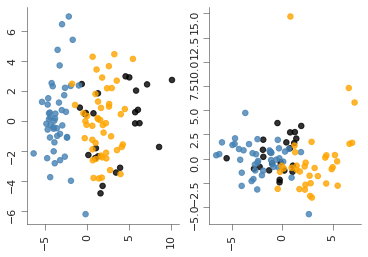

In [211]:
# cross_color_dict = {'cross-BW': 'steelblue', 
#                     'cross-PO': 'orange', 
#                     'BW-PO-cross-F1': 'black', 
#                     'BWxPO-cross-F2': 'grey'}

# #plot

# fig, ax = plt.subplots(nrows=1, ncols=2)

# #cry PCA
# cry_pca_colors = cry_df_filtered['species'].map(cross_color_dict)
# USV_pca_colors = USV_df_filtered['species'].map(cross_color_dict)

# #cry PCA
# ax[0].scatter(cry_df_filtered['pc1'], 
#                 cry_df_filtered['pc2'],
#                 c= cry_pca_colors,
#                 alpha = .8, 
#                 s=30)

# #USV PCA
# ax[1].scatter(USV_df_filtered['pc1'], 
#                 USV_df_filtered['pc2'],
#                 c= USV_pca_colors,
#                 alpha = .8, 
#                 s=30)

# #prettify
# swarm_plot.legend([],[], frameon=False)
# ax[0].set_ylabel('')
# ax[1].set_ylabel('')

# ax[0].set_ylabel('')
# # ax[0].set_ylim([-10,10])
# # ax[0].set_xlim([-10,10])

# ax[1].set_ylabel('')
# # ax[1].set_ylim([-1,10])
# # ax[1].set_xlim([-10,10])

# for axis in ['top','bottom','left','right']:
#     ax[0].spines[axis].set_linewidth(.5)
#     ax[1].spines[axis].set_linewidth(.5)
    
# ax[0].xaxis.set_tick_params(width=.5, rotation = 90)
# ax[0].yaxis.set_tick_params(width=.5, rotation = 90)
# ax[1].xaxis.set_tick_params(width=.5, rotation = 90)
# ax[1].yaxis.set_tick_params(width=.5, rotation = 90)
# sns.despine()

## merge F1 and F2 for plotting and analysis

In [271]:
#load f1 dataframe

#choose the age (p7 or p9)
f1_df_p7 = f1_df.loc[f1_df['age'].isin([7])]
f1_df_p7 = f1_df_p7.loc[f1_df_p7['removal_flag'] == 'fr0']
f1_df_p9 = f1_df.loc[f1_df['age'].isin([9])]
f1_df_p9 = f1_df_p9.loc[f1_df_p9['removal_flag'] == 'fr0']

#load f2 dataframe
#f2_df = f2_df.rename(columns={'cross_prefix':'species'}) #so you can color f1 and f2 using columns with the same name
#f2_df = f2_df.drop(columns = ['family', 'mic_chanel_prefix']) #so you can concat with f1 and f2 columns

#choose the age (p7 or p9)
f2_df_p7 = f2_df.loc[f2_df['age'].isin([7])]
f2_df_p7 = f2_df_p7.loc[f2_df_p7['removal_flag'] == 0]
f2_df_p9 = f2_df.loc[f2_df['age'].isin([9])]
f2_df_p9 = f2_df_p9.loc[f2_df_p9['removal_flag'] == 0]

#concatenate for plotting
assert sorted(f1_df_p7.columns) == sorted(f2_df_p7.columns)
assert sorted(f1_df_p9.columns) == sorted(f2_df_p9.columns)

f1_f2_df_p7 = pd.concat([f1_df_p7, f2_df_p7])
f1_f2_df_p9 = pd.concat([f1_df_p9, f2_df_p9])

In [275]:
f1_f2_df_p9['cry_duration_med'] = [i*1000 for i in f1_f2_df_p9['cry_duration_med']]
f1_f2_df_p9['USV_duration_med'] = [i*1000 for i in f1_f2_df_p9['USV_duration_med']]

In [272]:
len(f1_df_p9.loc[f1_df_p9['removal_flag'] == 'fr1'])

0

In [273]:
len(f2_df_p9.loc[f2_df_p9['removal_flag'] == 1])

0

array([0, 1])

## plot violin and PCA

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
excluding pups with fewer than 5 vocalizations...


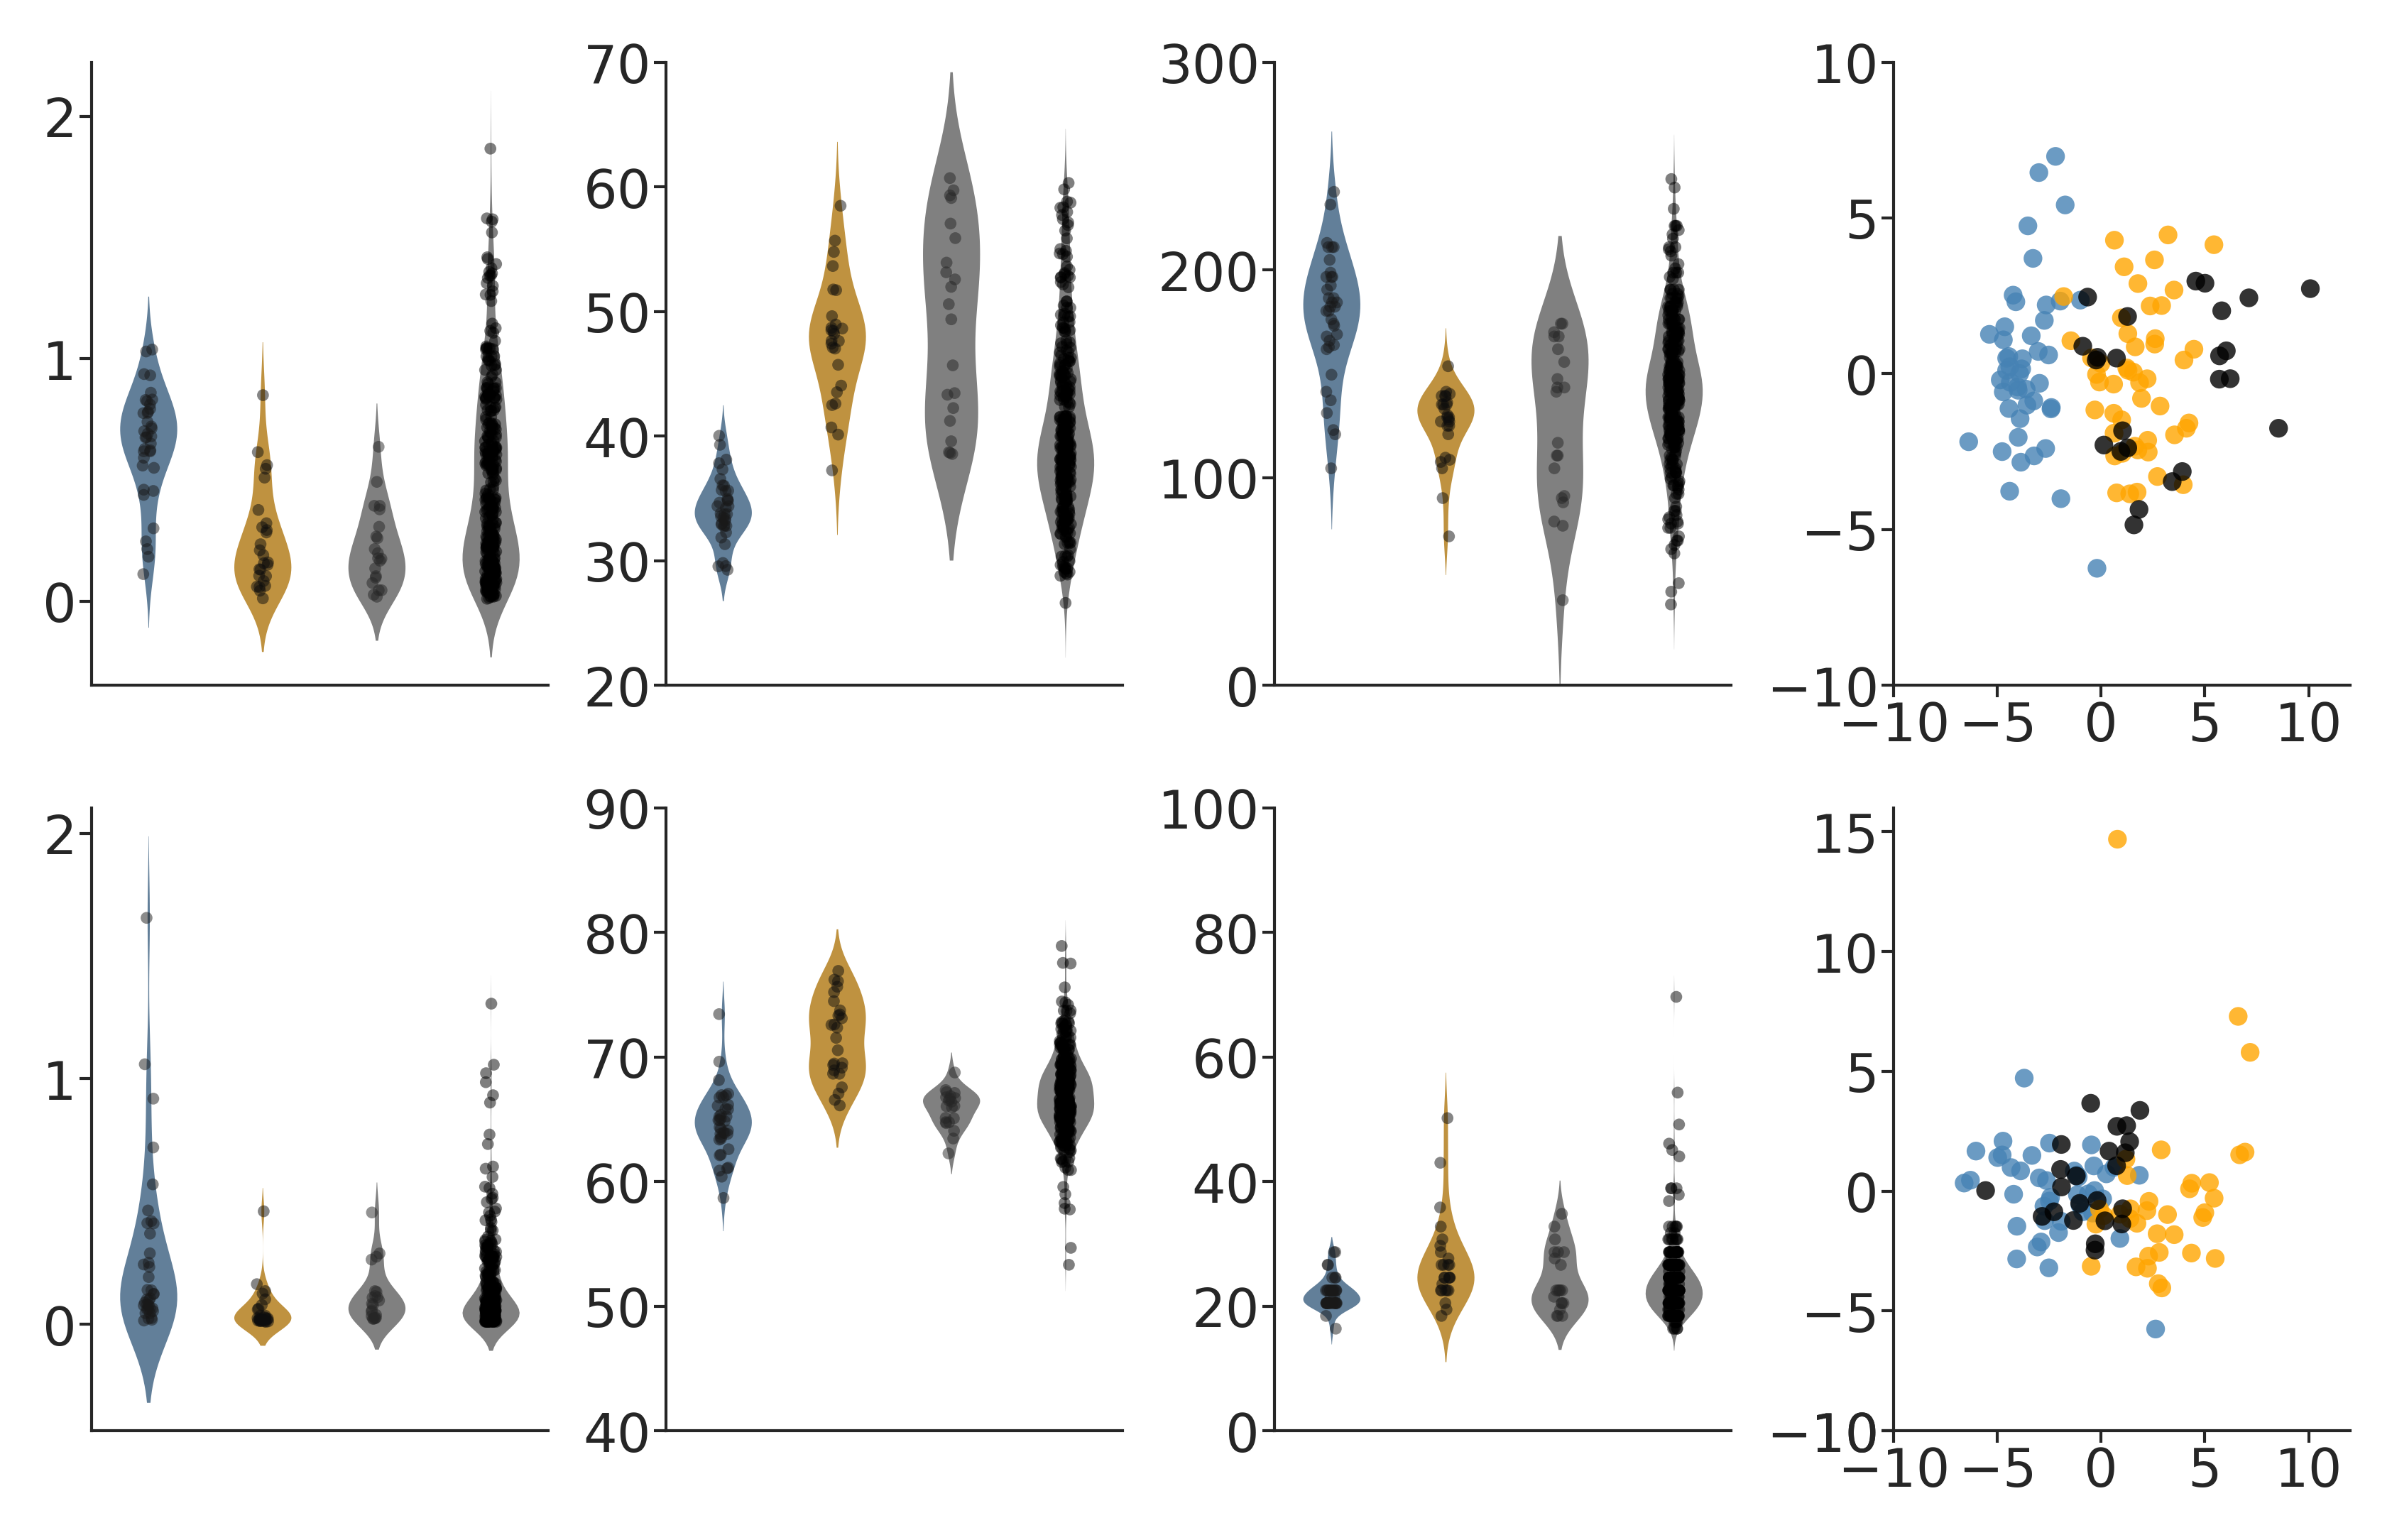

In [276]:
# plot all together

#choose to save or not
save = False

#plotting parameters

alpha = 0.5
jitter = 0.05
linewidth = 0
s = 2
fontsize = 9
linewidth = 0
violinwidth = 0.5

pca_s = 10
pca_alpha = .8

fontsize = 9
ytick_length = 2
ytick_pad = 0.5

#set the dataframe
data = f1_f2_df_p9

######################################################################################################################

#drop pups with fewer than min_voc_number vocalizations
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
min_voc_number = params_dict['figure_5']['min_voc_number'] #pup has to have at least this many vocs of each type to be considered
print('excluding pups with fewer than', min_voc_number, 'vocalizations...')
data = data.loc[(data['cry_count'] > min_voc_number) & (data['USV_count'] > min_voc_number)]

########################################################################################################################


cross_color_dict = {'cross-BW': 'steelblue', 
                    'cross-PO': 'orange', 
                    'BW-PO-cross-F1': 'grey', 
                    'BWxPO-cross-F2': 'grey'}

sns.set(style="ticks", color_codes=True)
fig, ax = plt.subplots(nrows=2,
                       ncols=4,
                       figsize=[5.5,3.5], 
                       sharex = False, 
                       sharey = False, 
                       constrained_layout=True, 
                       dpi=600)

#set rows (features) columns (genotype) and voc_type
features = ['_per_sec', '_meanfreq_med', '_duration_med']
voc_types = ['cry', 'USV']

#sepaarete tos you can plto separateekyt 
cry_pca_data_bwpo = cry_df_filtered.loc[~cry_df_filtered['species'].isin(['BW-PO-cross-F1'])]
cry_pca_data_f1 = cry_df_filtered.loc[cry_df_filtered['species'].isin(['BW-PO-cross-F1'])]

USV_pca_data_bwpo = USV_df_filtered.loc[~USV_df_filtered['species'].isin(['BW-PO-cross-F1'])]
USV_pca_data_f1 = USV_df_filtered.loc[USV_df_filtered['species'].isin(['BW-PO-cross-F1'])]

# get the colors
colors = pd.Series(data['species'].unique()).map(cross_color_dict)

#for each row
for i, voc_type in zip(range(ax.shape[0]), voc_types):
    
    #plot each column
    for j, feature in zip(range(ax.shape[1]), features):

        plot = sns.stripplot(x='species', 
                            y=voc_type+feature, 
                            data=data, 
                            alpha = alpha, 
                            size= s, 
                            jitter = jitter,  
                            color = 'black', 
                            dodge = False, 
                            hue = 'species', 
                            ax = ax[i,j], order=['cross-BW', 'cross-PO', 'BW-PO-cross-F1', 'BWxPO-cross-F2'])

        plot = sns.violinplot(x='species', 
                              y=voc_type+feature,
                              saturation=0.5,
                              data=data,       
                              width = violinwidth, 
                              linewidth = linewidth,   
                              dodge = False, 
                              palette = colors,
                              hue = 'species',  
                              inner = 'quartile',
                              ax = ax[i,j], order=['cross-BW', 'cross-PO', 'BW-PO-cross-F1', 'BWxPO-cross-F2'])
        
        #prettify
        plot.legend([],[], frameon=False)
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')
        for axis in ['top','bottom','left','right']:
            ax[i,j].spines[axis].set_linewidth(.5)
        for label in (ax[i,j].get_yticklabels() + ax[i,j].get_xticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(fontsize)

        ax[i,j].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
        ax[i,j].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

        ax[i,j].spines.bottom.set_visible(False)
        ax[i,j].set_xticks([], [])
        if feature == '_rate':
            ax[i,j].set_yticks([0,.5,1,1.5,2])
            ax[i,j].set_ylim([0,2])
        elif feature == '_meanfreq_med' and voc_type == 'cry':
            ax[i,j].set_yticks([20,30,40,50,60, 70])
            ax[i,j].set_ylim([20,70])
        elif feature == '_meanfreq_med' and voc_type == 'USV':
            ax[i,j].set_yticks([40,50,60,70,80, 90])
            ax[i,j].set_ylim([40,90])
        elif feature == '_duration_med' and voc_type == 'cry':
            ax[i,j].set_yticks([0,100,200,300])
            ax[i,j].set_ylim([0,300])
        elif feature == '_duration_med' and voc_type == 'USV':
            ax[i,j].set_yticks([0,20,40,60, 80, 100])
            ax[i,j].set_ylim([0,100])
#             ax[i,j].set_yticks([0,15,30,45, 60])
#             ax[i,j].set_ylim([0,60])
        sns.despine()
        
pca_cross_color_dict = {'cross-BW': 'steelblue', 
                    'cross-PO': 'orange', 
                    'BW-PO-cross-F1': 'black'}
        
        
#cry PCA
cry_pca_colors = cry_df_filtered['species'].map(pca_cross_color_dict)
USV_pca_colors = USV_df_filtered['species'].map(pca_cross_color_dict)       
        
        
#cry PCA - bw po
ax[0,3].scatter(cry_pca_data_bwpo['pc1'], 
                cry_pca_data_bwpo['pc2'],
                c= cry_pca_data_bwpo['species'].map(pca_cross_color_dict),
                alpha = pca_alpha, 
                linewidth = linewidth,
                s=pca_s)

#cry PCA - f1
ax[0,3].scatter(cry_pca_data_f1['pc1'], 
                cry_pca_data_f1['pc2'],
                c= cry_pca_data_f1['species'].map(pca_cross_color_dict),
                alpha = pca_alpha, 
                linewidth = linewidth,
                s=pca_s)

#USV PCA - bw po
ax[1,3].scatter(USV_pca_data_bwpo['pc1'], 
                USV_pca_data_bwpo['pc2'],
                c= USV_pca_data_bwpo['species'].map(pca_cross_color_dict),
                alpha = pca_alpha, 
                linewidth = linewidth,
                s=pca_s)

#USV PCA - f1
ax[1,3].scatter(USV_pca_data_f1['pc1'], 
                USV_pca_data_f1['pc2'],
                c= USV_pca_data_f1['species'].map(pca_cross_color_dict),
                alpha = pca_alpha, 
                linewidth = linewidth,
                s=pca_s)

#prettify
swarm_plot.legend([],[], frameon=False)
ax[0,3].set_ylabel('')
ax[1,3].set_ylabel('')

for axis in ['top','bottom','left','right']:
    ax[0,3].spines[axis].set_linewidth(.5)
    ax[1,3].spines[axis].set_linewidth(.5)
    
for label in (ax[0,3].get_yticklabels() + ax[0,3].get_xticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(fontsize)
            
for label in (ax[1,3].get_yticklabels() + ax[1,3].get_xticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(fontsize)
    
ax[0,3].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
ax[0,3].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

ax[0,3].set_yticks([-10,-5,0,5,10])
ax[0,3].set_ylim([-10,10])

ax[0,3].set_xticks([-10,-5,0,5,10])
ax[0,3].set_xlim([-10,12])

ax[1,3].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
ax[1,3].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

ax[1,3].set_yticks([-10,-10,-5,0,5,10,15])
ax[1,3].set_ylim([-10,16])

ax[1,3].set_xticks([-10,-5,0,5,10])
ax[1,3].set_xlim([-10,12])

if save:

    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_5/'
    save_name = ('_').join([save_name, 'min_voc', str(min_voc_number), '20221028'])
    #plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
    plt.savefig(os.path.join(save_dir, save_name)+'.svg')
    data.to_csv(os.path.join(save_dir, save_name)+'.csv', index=False)

## plot F2 trait correlations

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
excluding pups with fewer than 5 vocalizations...
0 : per_sec
1 : meanfreq_med
2 : duration_med


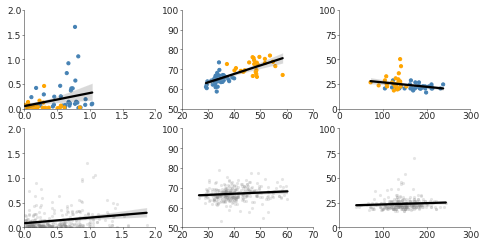

In [277]:
# plot all together

#choose to save or not
save = False

#set the dataframe
data = f1_f2_df_p9

#drop pups with fewer than min_voc_number vocalizations
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
min_voc_number = params_dict['figure_5']['min_voc_number'] #pup has to have at least this many vocs of each type to be considered
print('excluding pups with fewer than', min_voc_number, 'vocalizations...')
data = data.loc[(data['cry_count'] > min_voc_number) & (data['USV_count'] > min_voc_number)]

########################################################################################################################

fig, ax = plt.subplots(nrows=2,
                       ncols=3, 
                       figsize=[8,4], 
                       sharey=False)

alpha = 0.2
linewidth = 0
s = 10

#get the data
parental_data = data.loc[~data['species'].isin(['BW-PO-cross-F1', 'BWxPO-cross-F2'])]
F2_data = data.loc[data['species'].isin(['BWxPO-cross-F2'])]

parental_colors = parental_data['species'].map(cross_color_dict)
F2_colors = F2_data['species'].map(cross_color_dict)

#set rows (features_to_plot) columns (genotype) and voc_type
features_to_plot = ['per_sec', 'meanfreq_med', 'duration_med']
datasets = ['parental', 'F2']

#plot
for j, feature in zip(range(ax.shape[1]), features_to_plot):
    print(j,':', feature)
        
    ax[0,j].scatter(parental_data['cry_'+feature], 
                    parental_data['USV_'+feature], 
                    color = parental_colors,
                    s = s)
    
    sns.regplot(data = parental_data,
                x = 'cry_'+feature,
                y = 'USV_'+feature,
                fit_reg = True,
                color = 'grey',
                scatter_kws = {'s':0}, 
                line_kws = {'color':'black'},
                ax = ax[0,j]
               )

    for axis in ['top','bottom','left','right']:
            ax[0,j].spines[axis].set_linewidth(.5)

    sns.regplot(data = F2_data,
                x = 'cry_'+feature,
                y = 'USV_'+feature,
                fit_reg = True,
                color = 'grey',
                scatter_kws = {'alpha': alpha, 'linewidth':linewidth, 's':s}, 
                line_kws = {'color':'black'},
                ax = ax[1,j]
               )

    for axis in ['top','bottom','left','right']:
            ax[1,j].spines[axis].set_linewidth(.5)

    #prettify
    ax[0,j].xaxis.set_tick_params(width=.5, rotation = 90)
    ax[0,j].yaxis.set_tick_params(width=.5, rotation = 90)
    ax[1,j].xaxis.set_tick_params(width=.5, rotation = 90)
    ax[1,j].yaxis.set_tick_params(width=.5, rotation = 90)
    sns.despine()

    #prettify
    plot.legend([],[], frameon=False)
    ax[0,j].set_ylabel('')
    ax[0,j].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        ax[0,j].spines[axis].set_linewidth(.5)
    for label in (ax[0,j].get_yticklabels() + ax[0,j].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    ax[0,j].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    ax[0,j].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

    ax[1,j].set_ylabel('')
    ax[1,j].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        ax[1,j].spines[axis].set_linewidth(.5)
    for label in (ax[1,j].get_yticklabels() + ax[1,j].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

    ax[1,j].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    ax[1,j].xaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

    if feature == 'per_sec':
        for i in range(2):
            ax[i,j].set_yticks([0,.5,1,1.5,2])
            ax[i,j].set_ylim([0,2])
            ax[i,j].set_xticks([0,.5,1,1.5,2])
            ax[i,j].set_xlim([0,2])

    elif feature == 'meanfreq_med':
        for i in range(2):
            ax[i,j].set_xticks([20,30,40,50,60, 70])
            ax[i,j].set_xlim([20,70])
            ax[i,j].set_yticks([50,60,70,80,90, 100])
            ax[i,j].set_ylim([50,100])

    elif feature == 'duration_med':
        for i in range(2):
            ax[i,j].set_xticks([0,100,200,300])
            ax[i,j].set_xlim([0,300])
            ax[i,j].set_yticks([0,25,50,75,100])
            ax[i,j].set_ylim([0,100])




# Supplemental Figure ## (more UMAP)

## color UMAP by acoustic feature

In [279]:
#choose the directories you want and print the embeddings you have available to plot
coords_dir = amplitude_umap_HDBSCAN_labeled
coords_list = os.listdir(coords_dir)

print('coordinates available...')
for i in coords_list: 
    print(i)

coordinates available...
SW
BK
LL
LO
all_species_HDBSCAN_labels.csv
MU
PO
NB
all_species_HDBSCAN_labels.feather
MZ
BW
GO


In [280]:
#choose species decide what to save
species = 'BW'

save_umap_plot = False
save_labeled_umap_plot = False
save_label_verification = False

#load the coordinates
coords_path = glob.glob(coords_dir+species+'/*labeled.feather')[0]
df_umap = pd.read_feather(coords_path)

#just get the coordinates
df_umap_small = df_umap[['umap1', 'umap2', 'source_file', 'label']]


In [281]:
#merge UMAP coordinates with acoustic features

#the features csv for this species
features = pd.read_csv(glob.glob(os.path.join(amplitude_acoustic_features, species+'*'))[0])

#merge
df_umap_features = df_umap_small.merge(features, on= 'source_file')
df_umap_features['pup'] = [i.split('_clip')[0] for i in df_umap_features['source_file']]
df_umap_features['pupID'] = pd.factorize(df_umap_features['pup'])[0]
df_umap_features['age'] = [int(i.split('_')[10][1:]) for i in  df_umap_features['pup']]
df_umap_features['duration'] = df_umap_features['duration']*1000

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


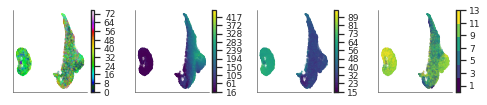

In [282]:
#plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib as mpl

save = False
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_1/supplement/'


colors = ['pupID', 'duration', 'meanfreq', 'age']
df = df_umap_features
fontsize= 9

fig, axes = plt.subplots(nrows =1, 
                         ncols = len(colors), 
                         figsize = [8,1.5], 
                         constrained_layout=True, 
                         sharex=True, 
                         sharey=True)

fig.subplots_adjust(wspace=0.5)


for color, i in zip(colors, range(len(colors))):
    
    if color == 'pupID':
        cmap = 'gist_ncar'
    else:
        cmap = 'viridis'
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
#     axes[i].set_xlim([-17,13])
#     axes[i].set_ylim([-10,20])
    
    im = axes[i].scatter(
        df['umap1'],
        df['umap2'],
        c = df[color],
        s = .1,
        alpha = .25, 
        cmap=cmap)
    
    for label in (axes[i].get_yticklabels() + axes[i].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    for axis in ['top','bottom','left','right']:
        axes[i].spines[axis].set_linewidth(.5)
        
 
    if color == 'pupID':
        bounds = np.linspace(0, np.max(df['pupID']), np.max(df['pupID'])+1)
        cmap = cm.get_cmap('gist_ncar')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical')
        cbar.ax.tick_params(labelsize=9) 
        
    elif color == 'age':
        bounds = np.linspace(0, 13, 7)
        cmap = cm.get_cmap('viridis')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical', 
                     ticks = [1, 3, 5, 7, 9, 11, 13])
        cbar.ax.tick_params(labelsize=9) 
        
    elif color == 'duration':
        bounds = np.round(np.linspace(np.min(df[color]), np.max(df[color])), decimals=0)
        cmap = cm.get_cmap('viridis')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical')
        cbar.ax.tick_params(labelsize=9) 
        
    elif color == 'meanfreq':
        bounds = np.round(np.linspace(np.min(df[color]), np.max(df[color])), decimals=0)
        cmap = cm.get_cmap('viridis')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical')
        cbar.ax.tick_params(labelsize=9) 

    axes[i].xaxis.set_tick_params(width=.5)
    axes[i].yaxis.set_tick_params(width=.5)
    axes[i].yaxis.set_tick_params(width=.5)
    axes[i].set_xticks([], [])
    axes[i].set_yticks([], [])

    sns.despine()


## get vocalization examples from UMAP

In [145]:
# #set seeds for reproducible sampling

# if species == 'SW':
#     USV_seed = 33333
#     cry_seed= 54321
# elif species == 'BK':
#     USV_seed = 987654
#     cry_seed = 12345
# elif species == 'LO':
#     USV_seed = 55555
#     cry_seed = 12345678
# elif species == 'NB':
#     USV_seed = 222223
#     cry_seed = 9876
# elif species == 'BW':
#     USV_seed = 1234567
#     cry_seed= 54321
# elif species == 'PO':
#     USV_seed = 22222
#     cry_seed= 87654321
# elif species == 'GO':
#     USV_seed = 1234567
#     cry_seed= 123456
# elif species == 'LL':
#     USV_seed = 1234567
#     cry_seed= 987654
# elif species == 'MU':
#     USV_seed = 123456789
# elif species == 'MZ':
#     USV_seed = 4444

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters


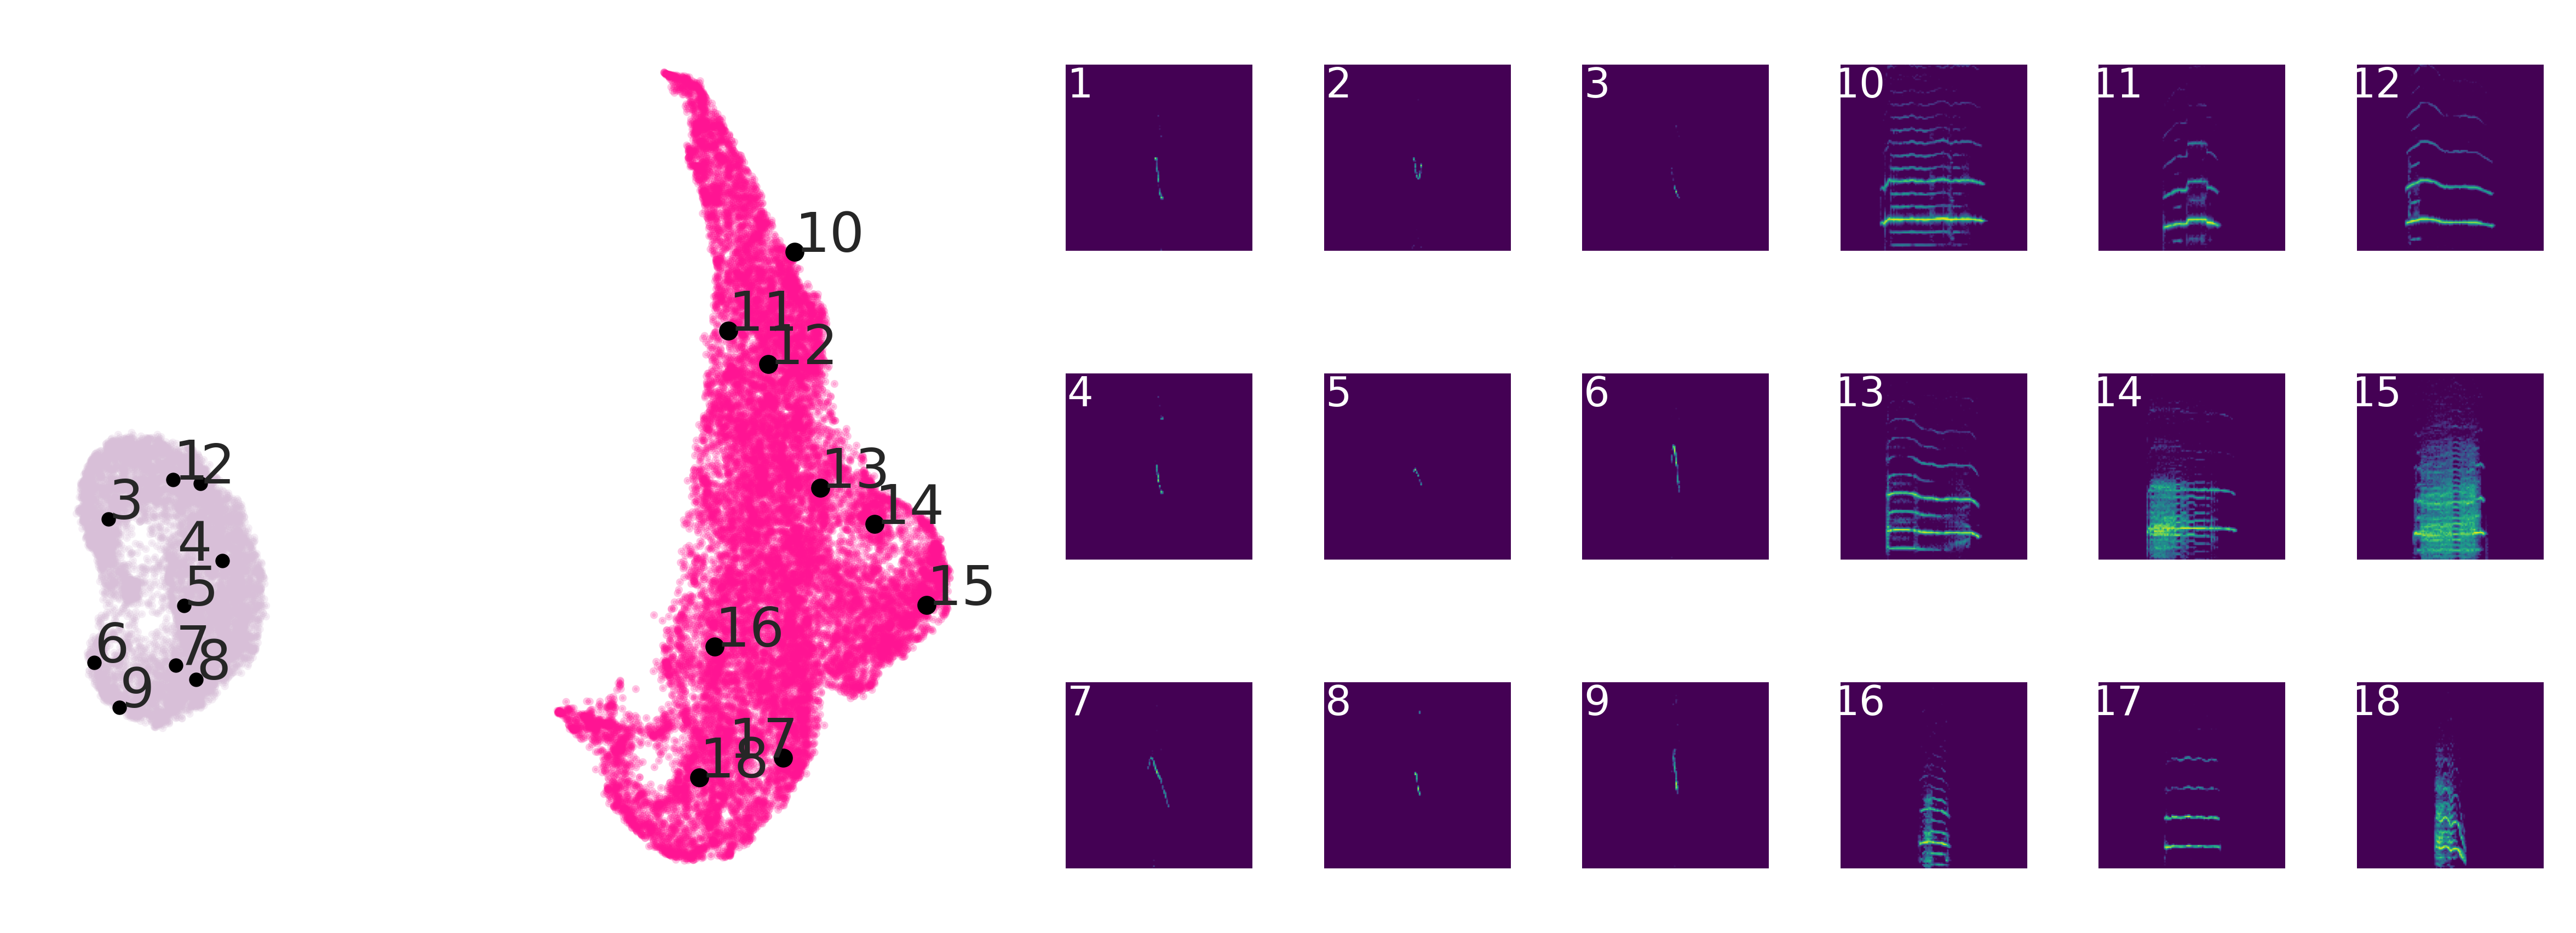

In [287]:
#plot

save=False

#load the samlping parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')

if species in ['MU', 'MZ']: 
    
    #set up the axes
    fig, axes = plt.subplot_mosaic(mosaic="AAAABCDEFG;AAAAHIJKLM;AAAANOPQRS", 
                                   figsize=[8,3], 
                                   layout='tight', 
                                   dpi=600)

    # #parameters
    label_color_dict = {1: 'deeppink', 0: 'thistle', -1:'thistle'}
    num_freq_bins=128
    num_time_bins=128
    dot_size = 10
    dot_alpha = 1

    #plot the umap
    axes["A"].scatter(
        df_umap['umap1'],
        df_umap['umap2'],
        c = df_umap['label'].map(label_color_dict),
        s = .5,
        alpha = .25, 
        cmap='viridis')

    USV_spec_axes = ["B", "C", "D", "H", "I", "J", "N", "O", "P"]
    cry_spec_axes = ["E", "F", "G", "K", "L", "M", "Q", "R", "S"]
    all_spec_axes  = USV_spec_axes + cry_spec_axes

    #remove ticks
    axes["A"].set_xticks([], [])
    axes["A"].set_yticks([], [])
    axes["A"].axis('off')
    sns.despine()
    for ax in all_spec_axes:
        axes[ax].set_xticks([], [])
        axes[ax].set_yticks([], [])
    fig.subplots_adjust(wspace=0, hspace = 0)

    #sample example vocalizations
    USV_seed = params_dict['supp_figure_1'][species]['USV_seed']
    USV_examples = df_umap.sample(n=18, random_state=USV_seed)

    #overlay them on the umap as black dots
    axes["A"].scatter(
        USV_examples['umap1'],
        USV_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha, 
        linewidth=0)
    
    #label them so you know which spec goes with which axis
    USV_examples = USV_examples.sort_values(by='umap2', ascending=False)
    USV_examples['plot_axis'] = USV_spec_axes + cry_spec_axes

    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,USV_examples['umap1'], USV_examples['umap2']):
        if txt == 4:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-10,0), textcoords = 'offset points')
        elif txt == 7:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for ax,label in zip(all_spec_axes, txt):
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']

        to_plot = USV_examples.loc[USV_examples['plot_axis'] == ax].drop(columns = columns_to_drop)

        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', extent = (num_freq_bins, 0, num_time_bins, 0 ))

        axes[ax].text(118, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

else:
    
    #set up the axes
    fig, axes = plt.subplot_mosaic(mosaic="AAAABCDEFG;AAAAHIJKLM;AAAANOPQRS", 
                                   figsize=[8,3], 
                                   layout='tight', 
                                   dpi=600)

    # #parameters
    label_color_dict = {1: 'deeppink', 0: 'thistle', -1:'thistle'}

    num_freq_bins=128
    num_time_bins=128
    dot_size = 10
    dot_alpha = 1

    #plot the umap
    axes["A"].scatter(
        df_umap['umap1'],
        df_umap['umap2'],
        c = df_umap['label'].map(label_color_dict),
        s = .5,
        alpha = .25, 
        cmap='viridis')

    USV_spec_axes = ["B", "C", "D", "H", "I", "J", "N", "O", "P"]
    cry_spec_axes = ["E", "F", "G", "K", "L", "M", "Q", "R", "S"]
    all_spec_axes  = USV_spec_axes + cry_spec_axes

    #remove ticks
    axes["A"].set_xticks([], [])
    axes["A"].set_yticks([], [])
    axes["A"].axis('off')
    sns.despine()
    for ax in all_spec_axes:
        axes[ax].set_xticks([], [])
        axes[ax].set_yticks([], [])
    fig.subplots_adjust(wspace=0, hspace = 0)

    #sample example vocalizations
    USV_seed = params_dict['supp_figure_1'][species]['USV_seed']
    USV_examples = df_umap.loc[df_umap['label'] == 0].sample(n=9, random_state=USV_seed)
    cry_seed = params_dict['supp_figure_1'][species]['cry_seed']
    cry_examples = df_umap.loc[df_umap['label'] == 1].sample(n=9, random_state=cry_seed)

    #overlay them on the umap as black dots
    axes["A"].scatter(
        USV_examples['umap1'],
        USV_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha, 
        linewidth=0)

    axes["A"].scatter(
        cry_examples['umap1'],
        cry_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha)

    #label them so you know which spec goes with which axis
    USV_examples = USV_examples.sort_values(by='umap2', ascending=False)
    cry_examples = cry_examples.sort_values(by='umap2', ascending=False)
    USV_examples['plot_axis'] = USV_spec_axes
    cry_examples['plot_axis'] = cry_spec_axes

    #annotate the dots with numbers and move some of them so they aren't on top of other numbers
    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,USV_examples['umap1'], USV_examples['umap2']):

        if txt == 4:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-10,0), textcoords = 'offset points')
        elif txt == 7:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    txt = [10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,cry_examples['umap1'], cry_examples['umap2']):
        if txt == 17:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-12,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    #put the USV spectrograms on their axes
    txt = [1,2,3,4,5,6,7,8,9]
    for ax,label in zip(USV_spec_axes, txt):
        
        #get the spectrogram
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']
        to_plot = USV_examples.loc[USV_examples['plot_axis'] == ax].drop(columns = columns_to_drop)
        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))      
        
        #plot
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', cmap='viridis', extent = (num_freq_bins, 0, num_time_bins, 0 ))
        axes[ax].text(118, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

    #put the cry spectrograms on their axes
    txt = [10,11,12,13,14,15,16,17,18]
    for ax, label in zip(cry_spec_axes, txt):
        
        #get the spectrogram
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']
        to_plot = cry_examples.loc[cry_examples['plot_axis'] == ax].drop(columns = columns_to_drop)
        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))
        
        #plot
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', cmap='viridis', extent = (num_freq_bins, 0, num_time_bins, 0 ))
        axes[ax].text(115, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

if save:
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_1/supplement'
    save_name = ('_').join([species,'spec_examples_20230125'+'.jpeg'])
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)
    


# Supplemental Figure ## (weights and heat loss)

# Supplemental Figure ## (inter-onset intervals)